In [199]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(20, 10), dpi=80)
import operator
from utils import get_dfs, extract_classes

<Figure size 1600x800 with 0 Axes>

In [200]:
# hdf_file_path = "../data/20221029-134728.hdf5"
# hdf_file_path = "../data/20221029-170143.hdf5"
# hdf_file_path = "../data/20221029-171117.hdf5"
# hdf_file_path = "../data/20221029-200201.hdf5"
# hdf_file_path = "../data/20221029-192231.hdf5"
hdf_file_path = "../data/20221029-202757.hdf5"
(df_raw, df_events, df_filtered, df_bands) = get_dfs(hdf_file_path)

In [201]:
df_events

label      data
2022-10-29 20:29:32.174300049  start   "repos"
2022-10-29 20:30:42.508399902  start    "lent"
2022-10-29 20:32:45.595000000  start   "repos"
2022-10-29 20:33:48.178800049  start  "rapide"
2022-10-29 20:35:53.861000000  start   "repos"
2022-10-29 20:36:57.444399902  start  "rapide"
2022-10-29 20:39:00.062899902  start   "repos"
2022-10-29 20:40:04.211399902  start    "lent"
2022-10-29 20:42:04.097399902  start   "repos"
2022-10-29 20:43:16.161500000   stop   "repos"
2022-10-29 20:43:17.493899902   stop   "repos"

# Utils functions

In [211]:
'''
paths in hdf5 file:

(key '/raw')
(key '/events')
(key '/filtered')
(key '/bands')
'''


def split_df_by_event(ts_df, event_df):
    classes = extract_classes(event_df)
    tmp_event_df = event_df.copy()
    result = {}
    for c in range(len(classes)):
        if classes[c] not in result:
            result[classes[c]] = []
        start_events = event_df.loc[(event_df.data == classes[c])]
        ref_start_date = start_events.index[0]
        start = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'start')].index[0]
        end = event_df.loc[(event_df.data == classes[c]) & (event_df.label == 'stop')].index

        if len(end) == 0:
            # Get the row after ref_start_date
            end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]
        else:
            end = end[0]

        if c < len(classes) - 2:
            tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])
        result[classes[c]].append(ts_df[start:end])
    return result

def display_ts(ts_df, title):
    ts = ts_df.cumsum()
    ts.plot(title="Multiply the values for each row with the values from the previous row", figsize=(20, 10));
    ts_df.plot(title=title, figsize=(20, 10))
    plt.show()

def two_side_view(ts_df, title=""):
    curr_df = ts_df.copy()
    x = curr_df.index
    y1 = curr_df['Fpz'].values

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(16,5), dpi= 120)
    plt.fill_between(x, y1=y1, y2=-y1, alpha=0.5, linewidth=2, color='seagreen')
    plt.ylim(curr_df.min().min()*2, curr_df.max().max()*2)
    plt.title(f'{title} (Two Side View)', fontsize=16)
    plt.hlines(y=0, xmin=np.min(curr_df.index), xmax=np.max(curr_df.index), linewidth=.5)
    plt.show()

def get_df_range_event(ts_df, event_df, d):
    start_events = event_df.loc[(event_df.data == d)]
    ref_start_date = start_events.index[0]
    start = event_df.loc[(event_df.data == d) & (event_df.label == 'start')].index[0]
    end = event_df.loc[(event_df.data == d) & (event_df.label == 'stop')].index

    if len(end) == 0:
        # Get the row after ref_start_date
        end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]
    else:
        end = end[0]

    print("range => ")
    print(end - start)

    return ts_df[start:end].head(1000)

def seasonal_decompose_ts(ts_df, title):
    result = sm.tsa.seasonal_decompose(ts_df, model='multiplicative')
    result.plot()
    plt.show()

def viz_by_class(ts_df, event_df):
    '''
        This function will plot the time series for each class
    '''
    classes = extract_classes(event_df)
    tmp_event_df = event_df.copy()
    fig, axes = plt.subplots(nrows=len(classes), ncols=1, figsize=(20, 30))

    for c in range(len(classes)):
        ts = get_df_range_event(ts_df, tmp_event_df, classes[c])
        ts.plot(ax=axes[c], title=classes[c])
        if c < len(classes) - 2:
            tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])

    fig.tight_layout()
    plt.show()

def viz_ts_by_class(ts_df, event_df):
    '''
        This function will plot the time series for each class
    '''
    classes = extract_classes(event_df)
    tmp_event_df = event_df.copy()
    # fig, axes = plt.subplots(nrows=len(classes), ncols=1, figsize=(20, 30))

    for c in range(len(classes)):
        ts = get_df_range_event(ts_df, tmp_event_df, classes[c])


        tt_tmp = ts.copy()
        tt_tmp.index = pd.to_datetime(tt_tmp.index).to_period('ms')
        display(tt_tmp)
        tt_tmp = tt_tmp.mask(tt_tmp.lt(float(1))).ffill().fillna(float(1)).astype('float32')

        two_side_view(ts_df, classes[c])

        decomposition=sm.tsa.seasonal_decompose(x=tt_tmp['Fpz'],model='additive', extrapolate_trend='freq', period=13)

        decomposition_trend=decomposition.trend
        ax= decomposition_trend.plot(figsize=(20,10))
        ax.set_xlabel('Date')
        ax.set_ylabel('Trend of time series')
        ax.set_title(f'Trend values of the time series for {classes[c]}')
        plt.show()

        decomposition_residual=decomposition.resid
        ax= decomposition_residual.plot(figsize=(20,10))
        ax.set_xlabel('Date')
        ax.set_ylabel('Residual of time series')
        ax.set_title(f'Residual values of the time series for {classes[c]}')
        plt.show()

        decomposition_seasonal=decomposition.seasonal
        ax= decomposition_seasonal.plot(figsize=(20,10))
        ax.set_xlabel('Date')
        ax.set_ylabel('Seasonal of time series')
        ax.set_title(f'Seasonal values of the time series for {classes[c]}')
        plt.show()

        if c < len(classes) - 2:
            tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])

    

In [203]:
df_raw.index[-1]

Timestamp('2022-10-29 20:45:34.325438')

# Global viz

Filtered data


Fpz
2022-10-29 20:27:59.535438   0.000000
2022-10-29 20:27:59.545438  10.438289
2022-10-29 20:27:59.555438  35.629969
2022-10-29 20:27:59.565438  47.554233
2022-10-29 20:27:59.575438  28.875561
...                               ...
2022-10-29 20:45:34.105438  -1.974072
2022-10-29 20:45:34.115438  -0.356100
2022-10-29 20:45:34.125438   1.355186
2022-10-29 20:45:34.135438  -4.522857
2022-10-29 20:45:34.145438  -6.081921

[105462 rows x 1 columns]

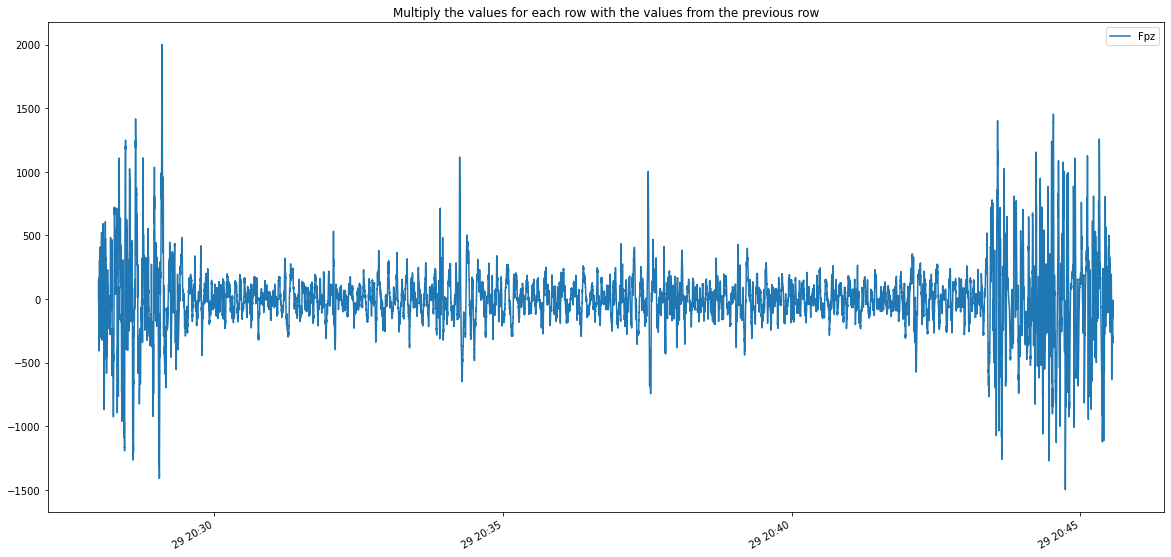

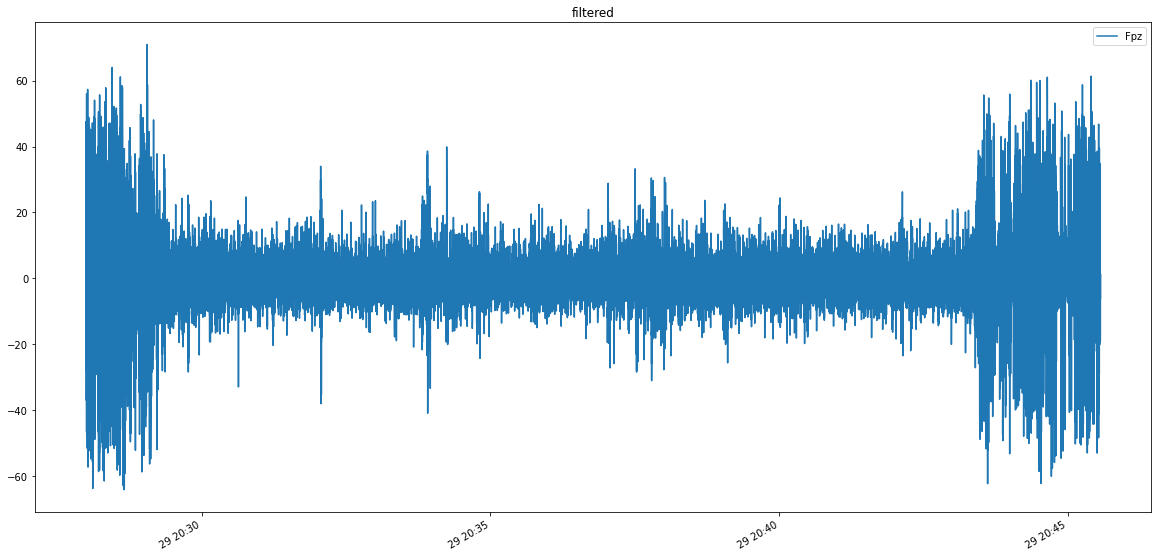

In [218]:
print("Filtered data")
display(df_filtered)
display_ts(df_filtered, "filtered")

# Viz by class

range => 
0 days 00:13:43.987199951
range => 
0 days 00:02:03.086600098
range => 
0 days 00:10:30.566500


/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/2140761302.py:37: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]
/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/2140761302.py:37: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


range => 
0 days 00:02:05.682199951
range => 
0 days 00:07:22.300500
range => 
0 days 00:02:02.618500
range => 
0 days 00:04:16.098600098


/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/2140761302.py:37: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]
/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/2140761302.py:37: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


range => 
0 days 00:01:59.886000
range => 
0 days 00:01:12.064100098


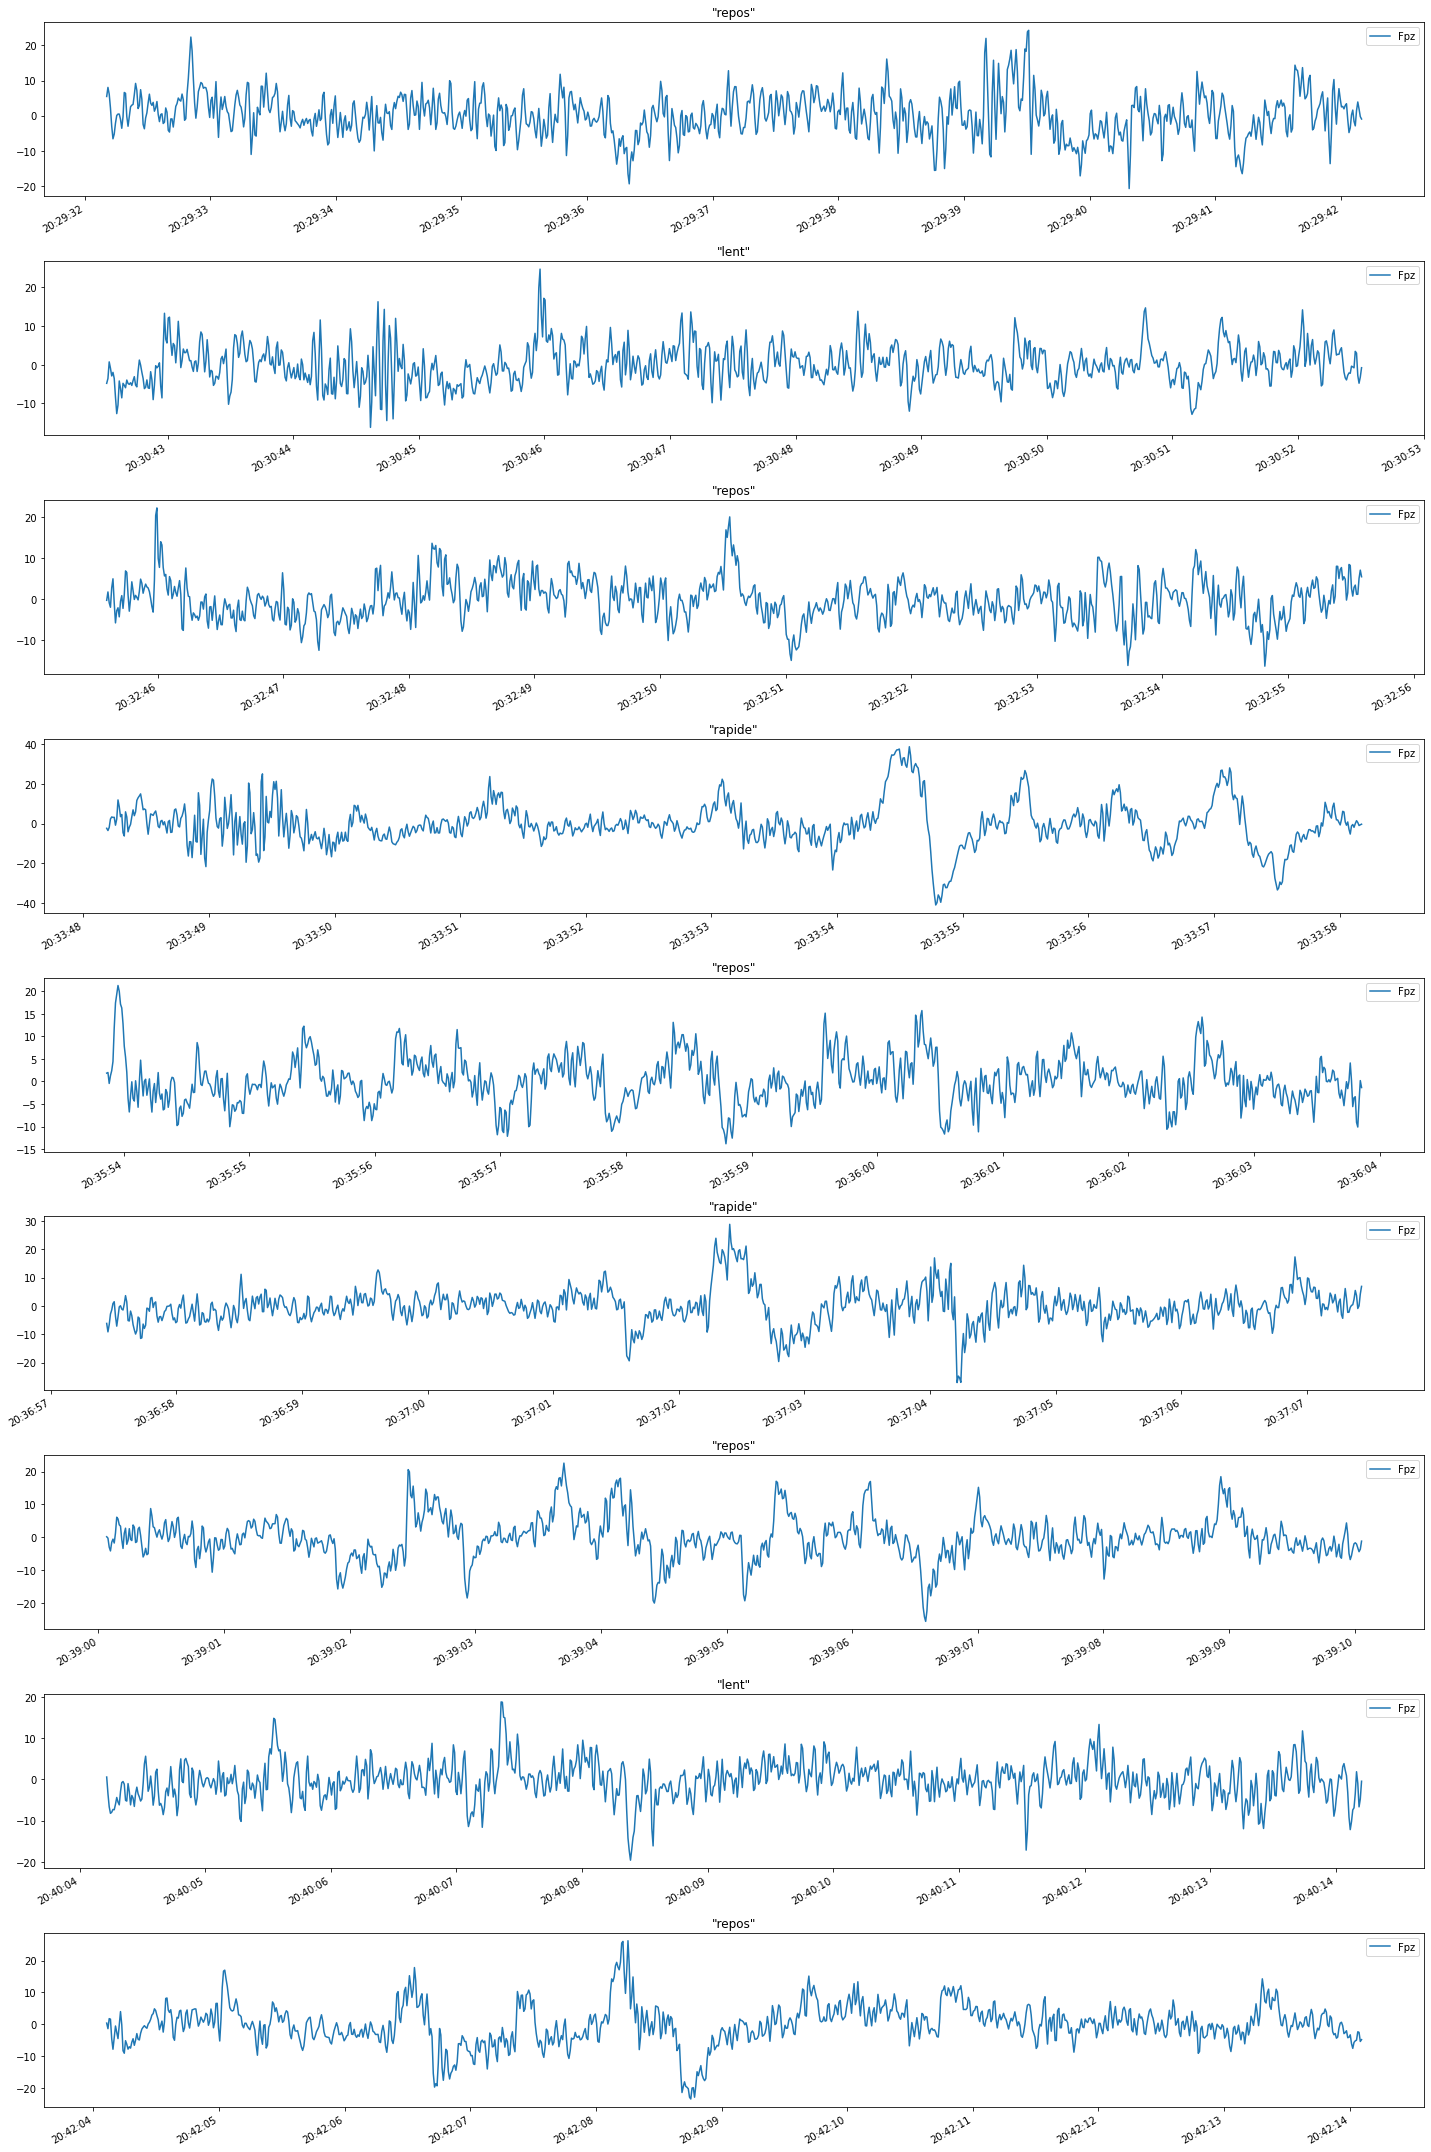

In [204]:
viz_by_class(df_filtered, df_events)

# Clean data

In [156]:
(df_raw, df_events, df_filtered, df_bands) = get_dfs()

# Delete first row
tmp_event_df = df_events.copy()
tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])
display(tmp_event_df)
tmp_event_df = tmp_event_df.drop(tmp_event_df.index[0])
display(tmp_event_df)

In [157]:
df_events

label           data
2022-10-29 17:11:28.111000000  start        "repos"
2022-10-29 17:12:16.822699951  start       "rapide"
2022-10-29 17:13:23.859899902  start        "repos"
2022-10-29 17:14:01.688500000  start         "lent"
2022-10-29 17:14:58.447899902  start       "rapide"
2022-10-29 17:16:08.534000000  start        "repos"
2022-10-29 17:17:06.076899902  start         "lent"
2022-10-29 17:18:01.912300049  start        "repos"
2022-10-29 17:18:52.960600098  start         "lent"
2022-10-29 17:20:00.910899902  start        "repos"
2022-10-29 17:20:29.843800049  start       "rapide"
2022-10-29 17:21:08.799800049  start        "repos"
2022-10-29 17:21:35.926600098  start         "lent"
2022-10-29 17:22:17.615500000  start       "rapide"
2022-10-29 17:23:14.126399902  start         "lent"
2022-10-29 17:24:28.374899902  start        "repos"
2022-10-29 17:25:06.177100098  start       "rapide"
2022-10-29 17:25:23.774199951  start  "interuption"
2022-10-29 17:25:51.358199951  start        "repos"
2022-10-29 17:25:53.089699951  start        "repos"
2022-10-29 17:26:32.697199951  start       "rapide"
2022-10-29 17:26:52.707399902  start  "interuption"
2022-10-29 17:27:01.656800049  start          "fin"
2022-10-29 17:27:23.260303000   stop          "fin"

# Time series viz global

Filtered data


Fpz
2022-10-29 17:01:44.688090   0.000000
2022-10-29 17:01:44.698090   1.965779
2022-10-29 17:01:44.708090   4.075831
2022-10-29 17:01:44.718090   1.576172
2022-10-29 17:01:44.728090   0.476386
...                               ...
2022-10-29 17:09:36.498090 -41.177331
2022-10-29 17:09:36.508090 -40.771141
2022-10-29 17:09:36.518090 -40.957428
2022-10-29 17:09:36.528090 -40.100113
2022-10-29 17:09:36.538090 -34.315932

[47186 rows x 1 columns]

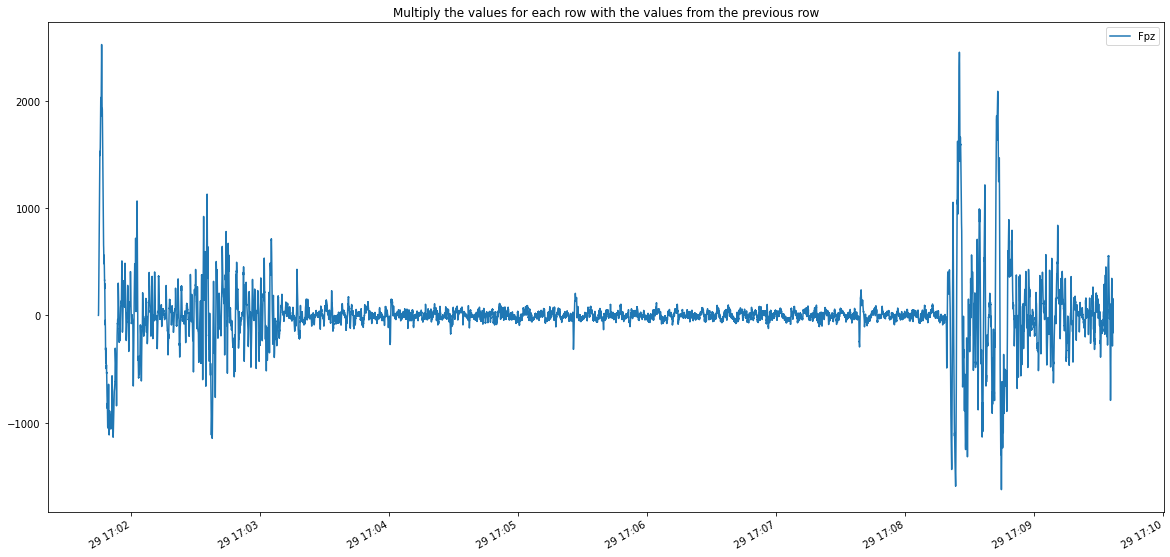

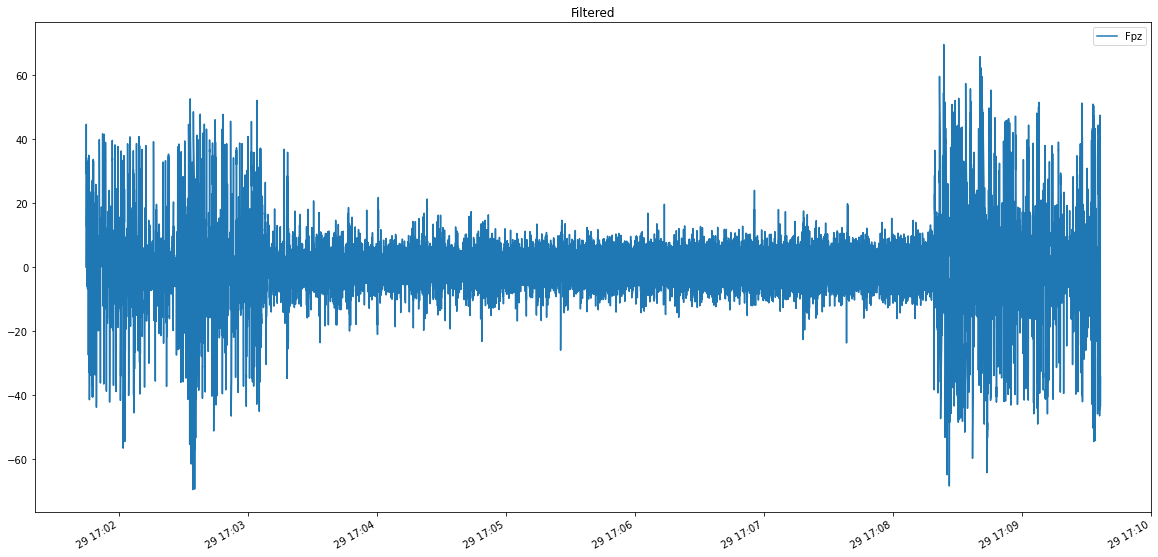

In [154]:
print("Filtered data")
display(df_filtered)
display_ts(df_filtered, "Filtered")

# Time series viz by class

range => 
0 days 00:13:43.987199951


Fpz
2022-10-29 20:29:32.175  5.463400
2022-10-29 20:29:32.185  8.047971
2022-10-29 20:29:32.195  6.152478
2022-10-29 20:29:32.205  2.183929
2022-10-29 20:29:32.215 -3.015791
...                           ...
2022-10-29 20:29:42.125  1.464011
2022-10-29 20:29:42.135  3.902183
2022-10-29 20:29:42.145  1.934928
2022-10-29 20:29:42.155 -0.264783
2022-10-29 20:29:42.165 -0.948468

[1000 rows x 1 columns]

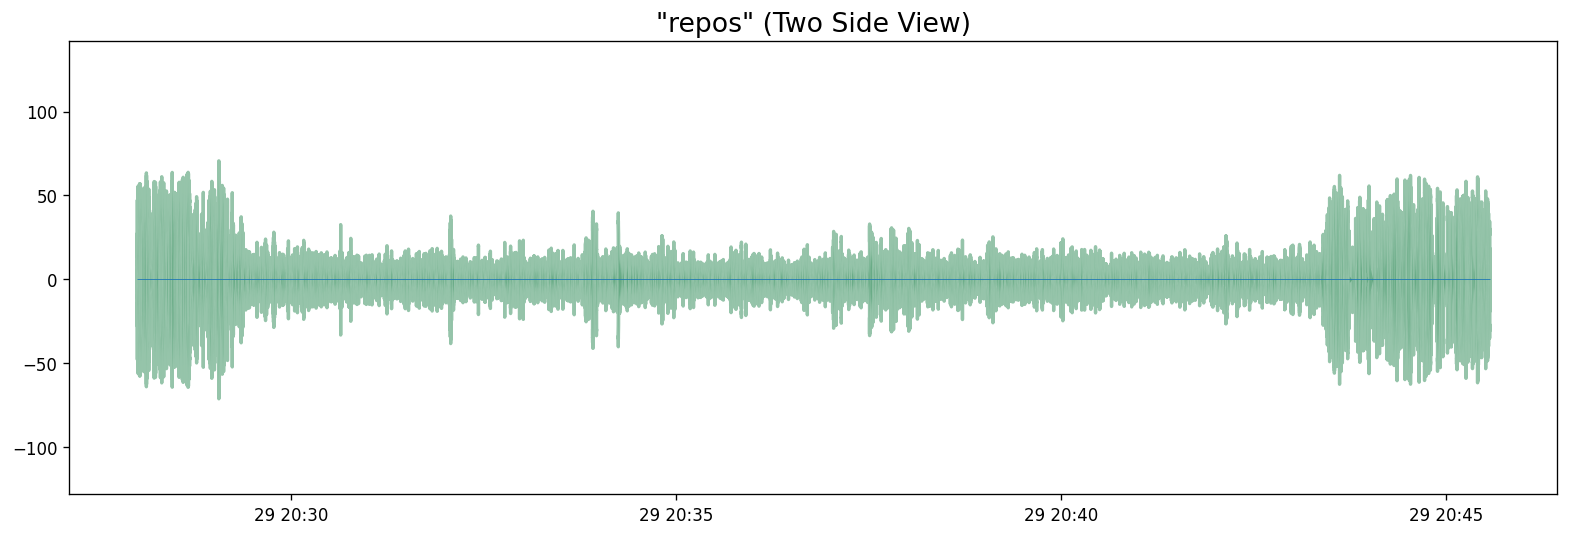

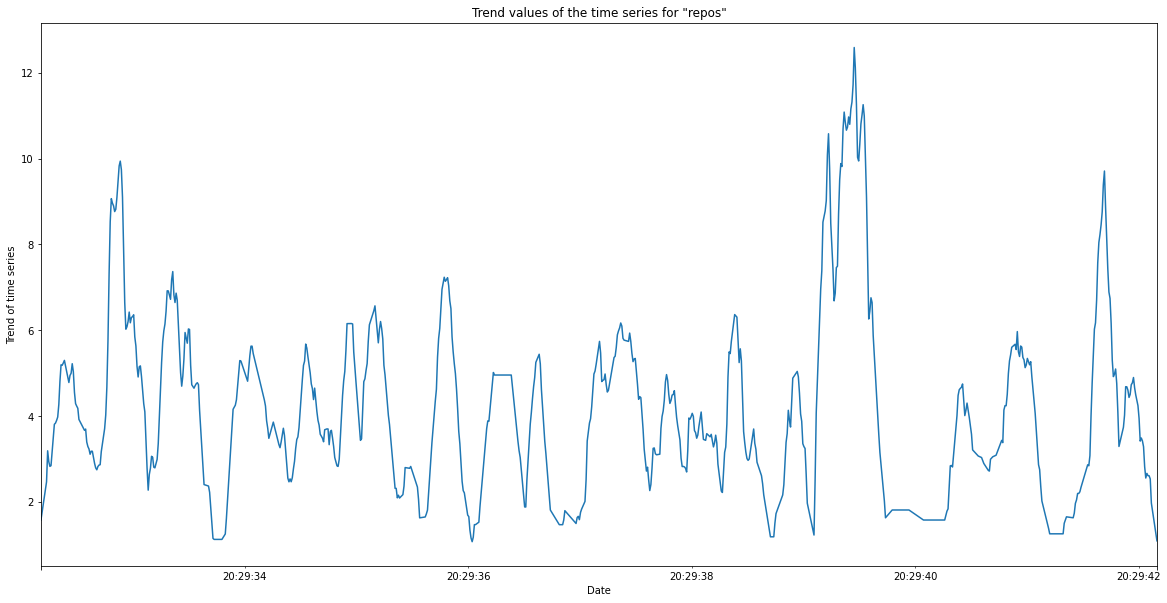

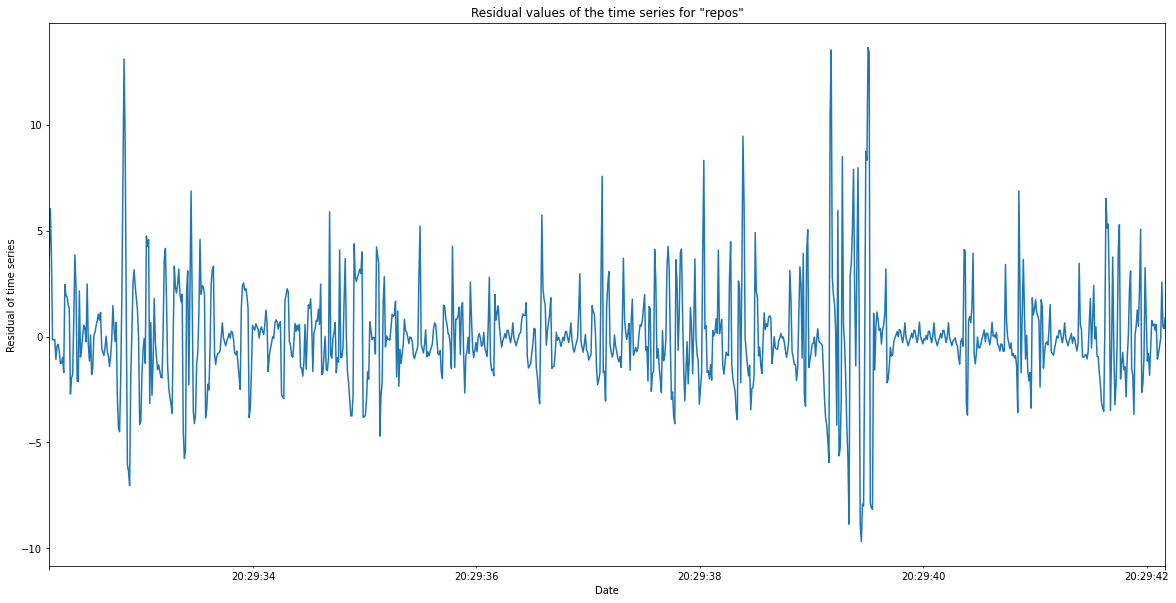

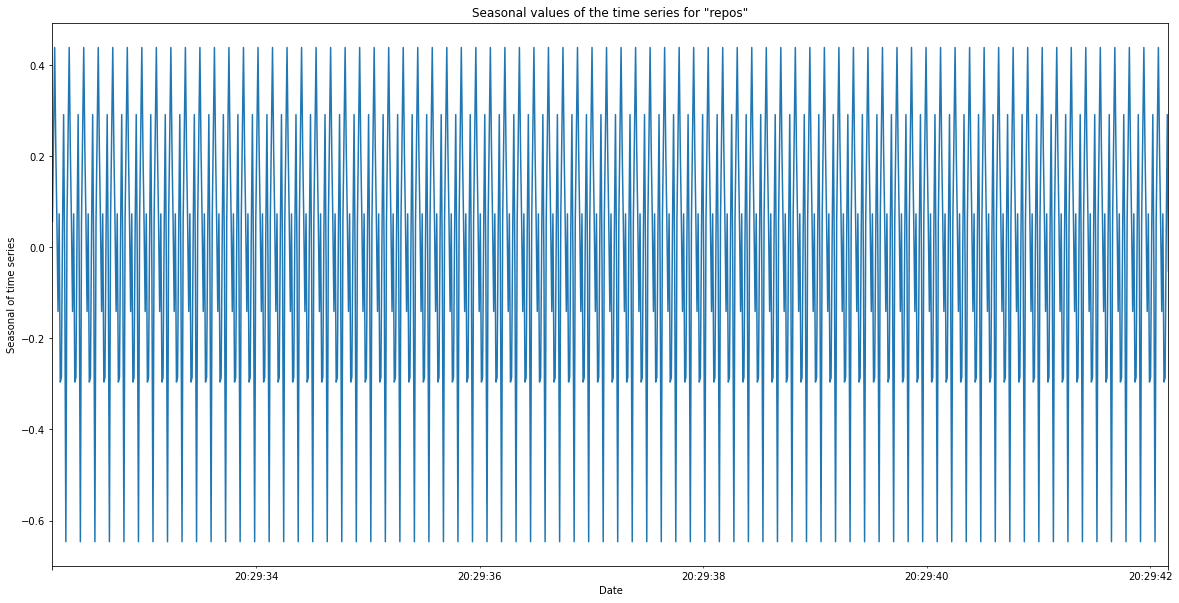

range => 
0 days 00:02:03.086600098


/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/3513213301.py:37: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


Fpz
2022-10-29 20:30:42.515 -4.799924
2022-10-29 20:30:42.525 -3.546056
2022-10-29 20:30:42.535  0.742533
2022-10-29 20:30:42.545 -0.886070
2022-10-29 20:30:42.555 -2.893115
...                           ...
2022-10-29 20:30:52.465  3.004964
2022-10-29 20:30:52.475 -2.780263
2022-10-29 20:30:52.485 -4.774548
2022-10-29 20:30:52.495 -3.183831
2022-10-29 20:30:52.505 -0.761118

[1000 rows x 1 columns]

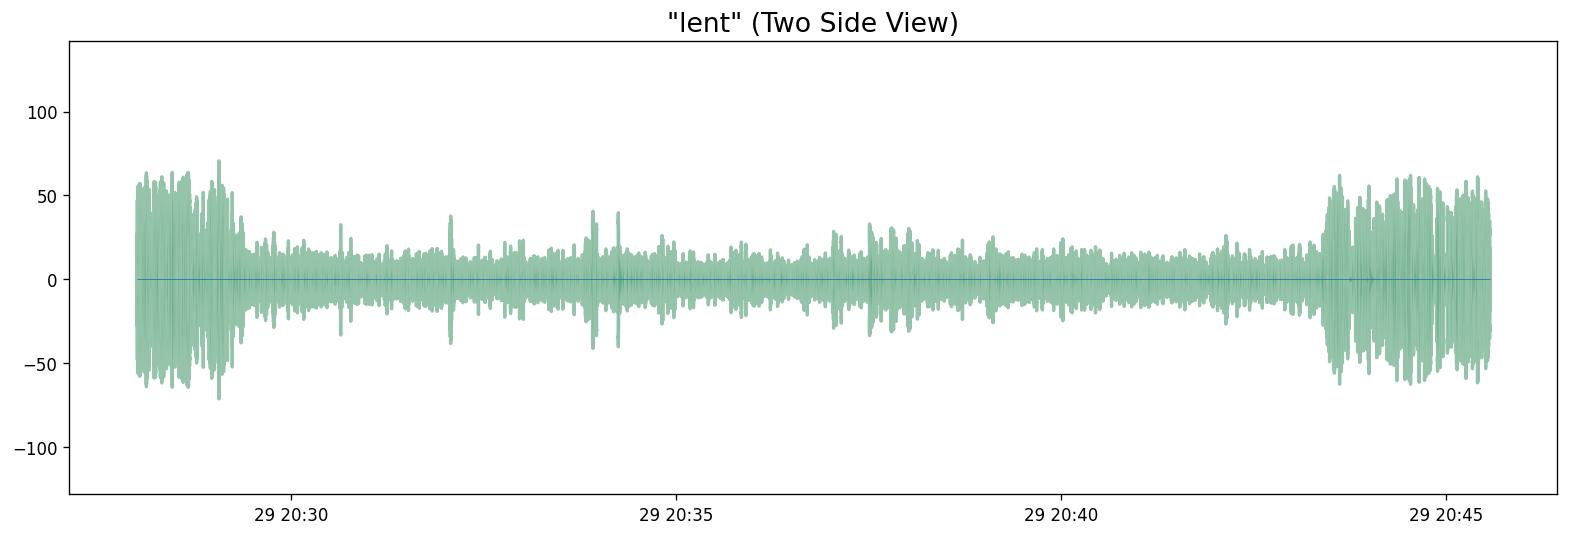

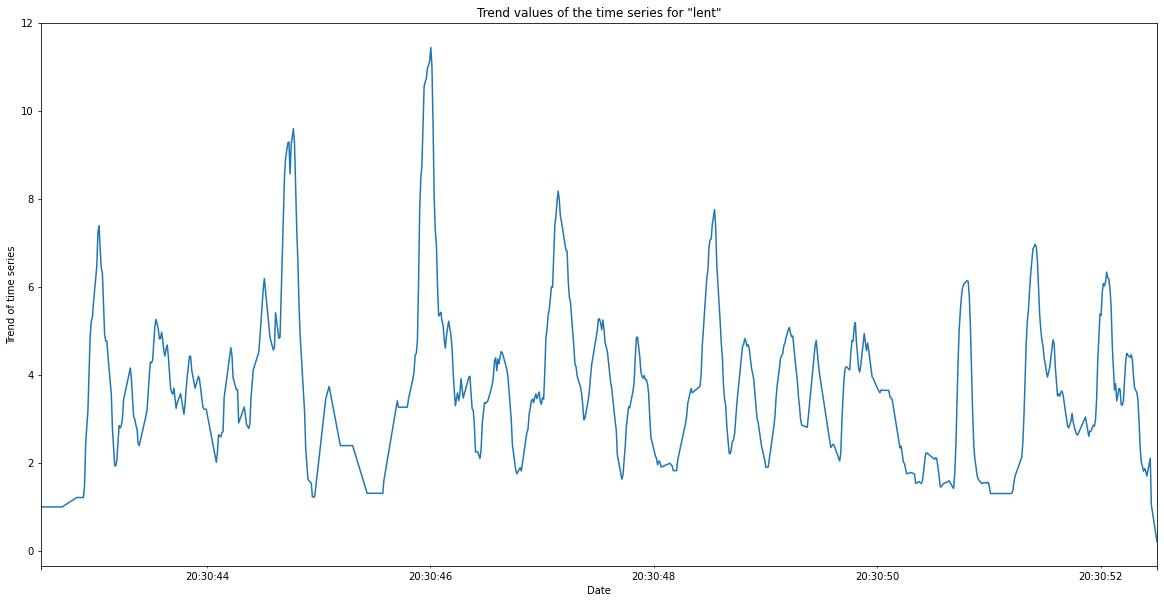

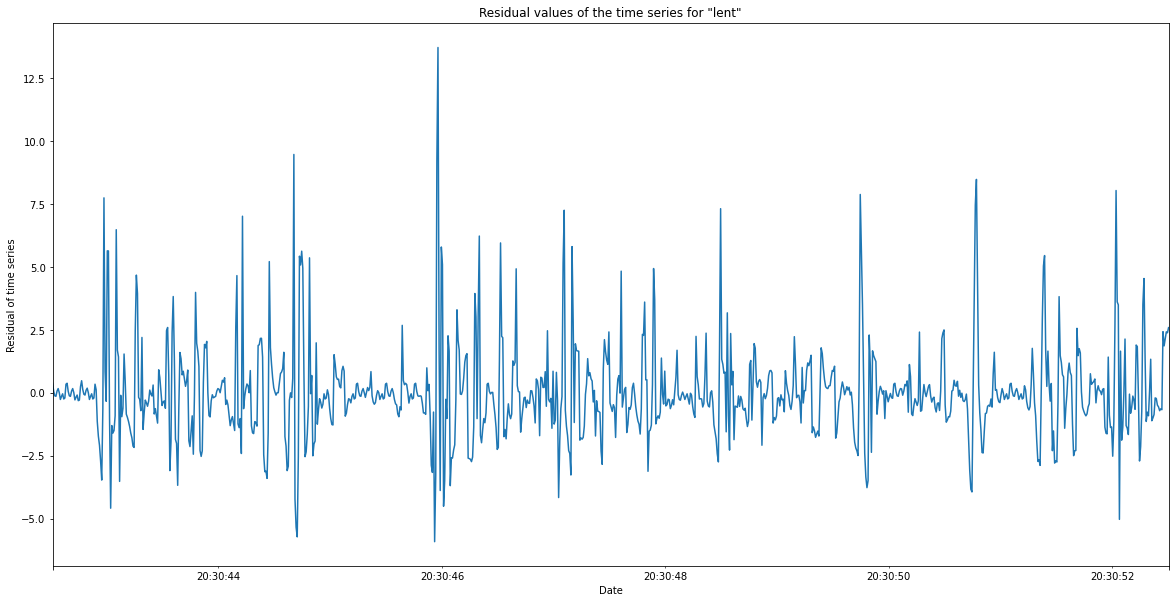

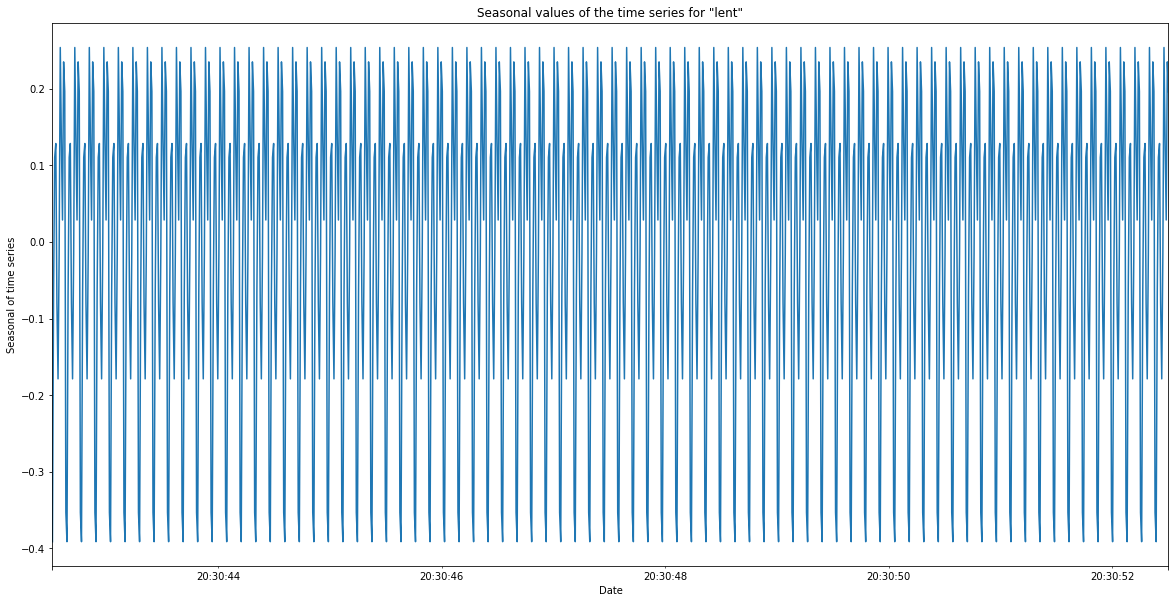

range => 
0 days 00:10:30.566500


Fpz
2022-10-29 20:32:45.595 -0.278046
2022-10-29 20:32:45.605  1.774704
2022-10-29 20:32:45.615 -0.873317
2022-10-29 20:32:45.625 -1.967068
2022-10-29 20:32:45.635  2.795662
...                           ...
2022-10-29 20:32:55.545  1.199448
2022-10-29 20:32:55.555  1.191984
2022-10-29 20:32:55.565  5.076070
2022-10-29 20:32:55.575  7.099584
2022-10-29 20:32:55.585  5.481937

[1000 rows x 1 columns]

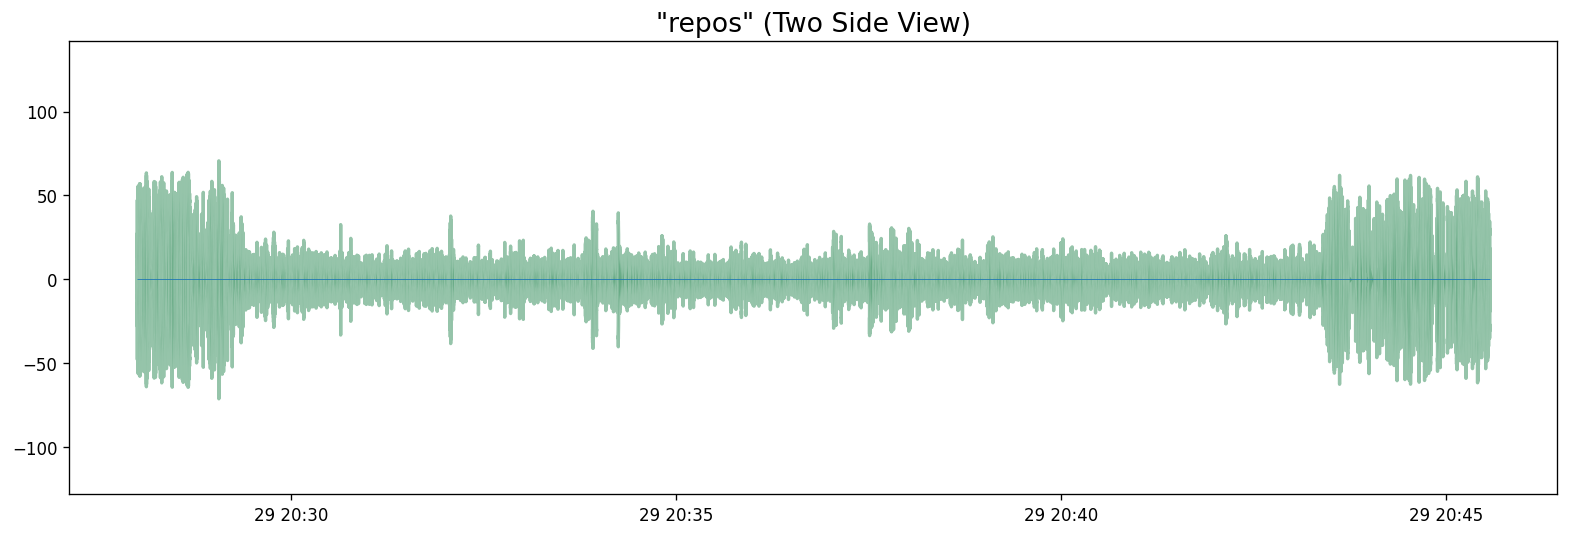

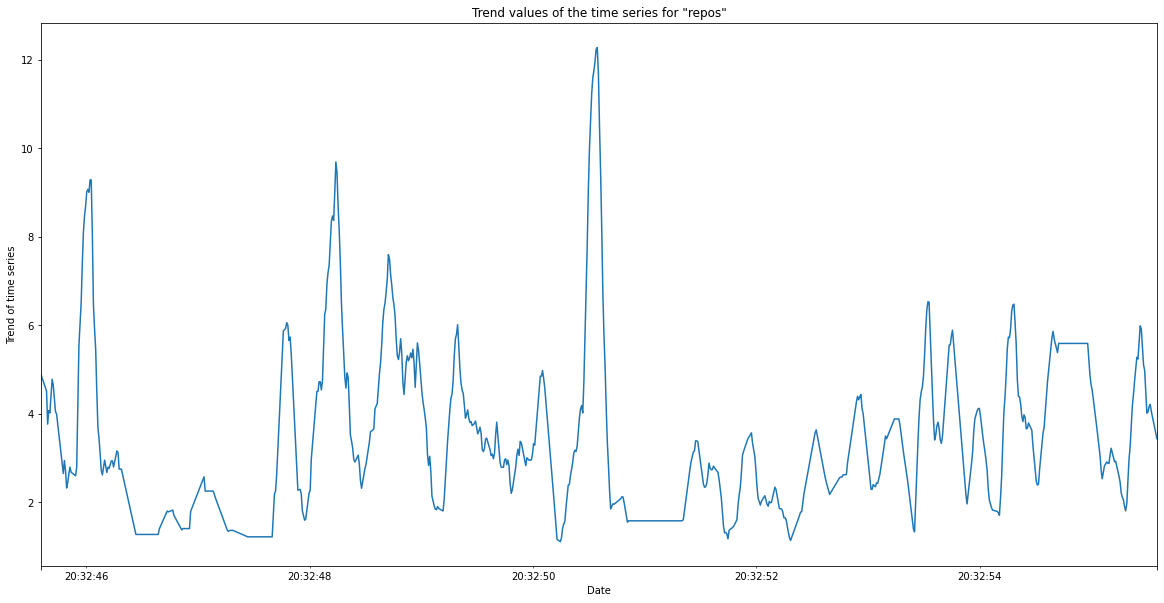

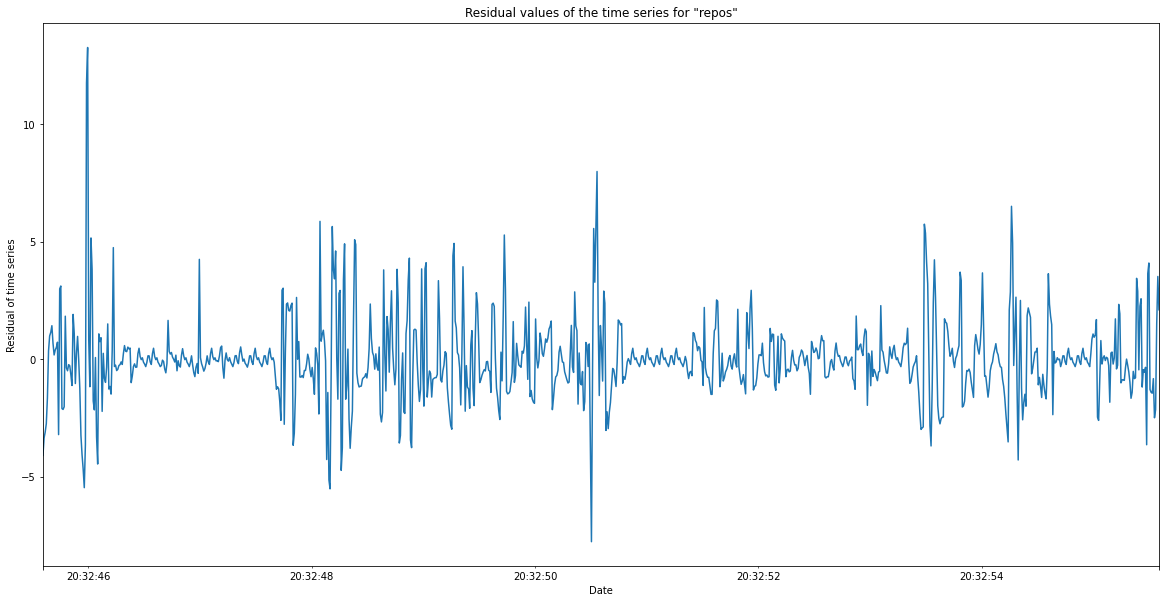

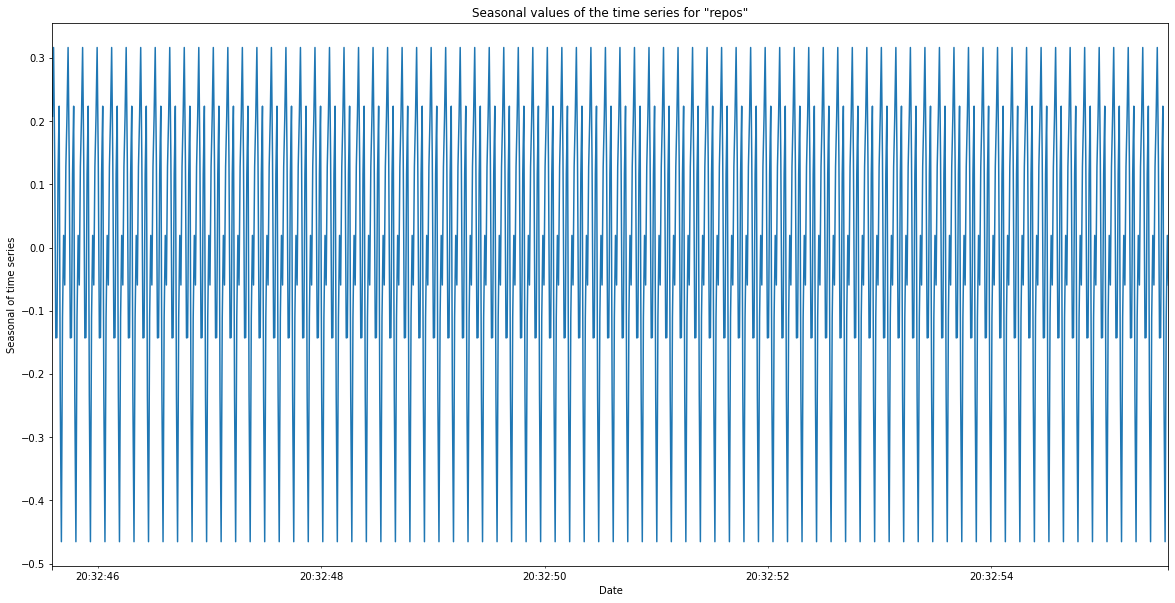

range => 
0 days 00:02:05.682199951


/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/3513213301.py:37: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


Fpz
2022-10-29 20:33:48.185 -2.333127
2022-10-29 20:33:48.195 -3.463797
2022-10-29 20:33:48.205 -1.916791
2022-10-29 20:33:48.215  2.330921
2022-10-29 20:33:48.225  3.358076
...                           ...
2022-10-29 20:33:58.135  1.487578
2022-10-29 20:33:58.145  0.584172
2022-10-29 20:33:58.155 -0.951137
2022-10-29 20:33:58.165 -0.582444
2022-10-29 20:33:58.175 -0.286426

[1000 rows x 1 columns]

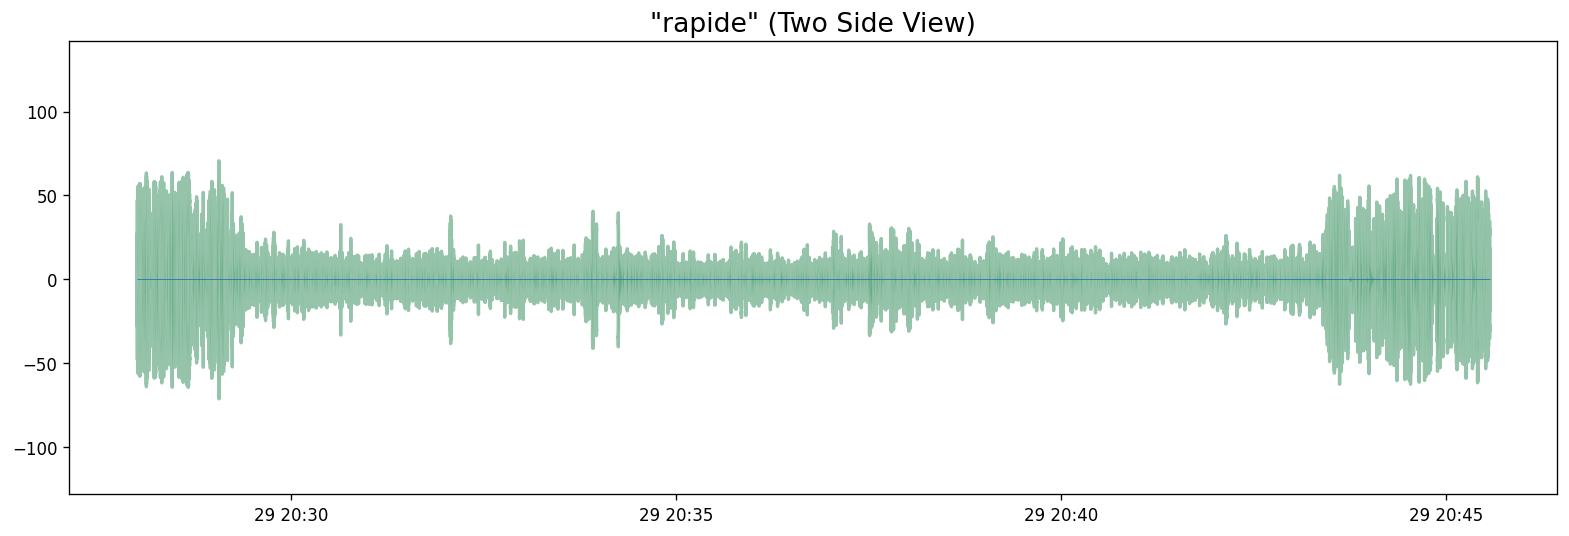

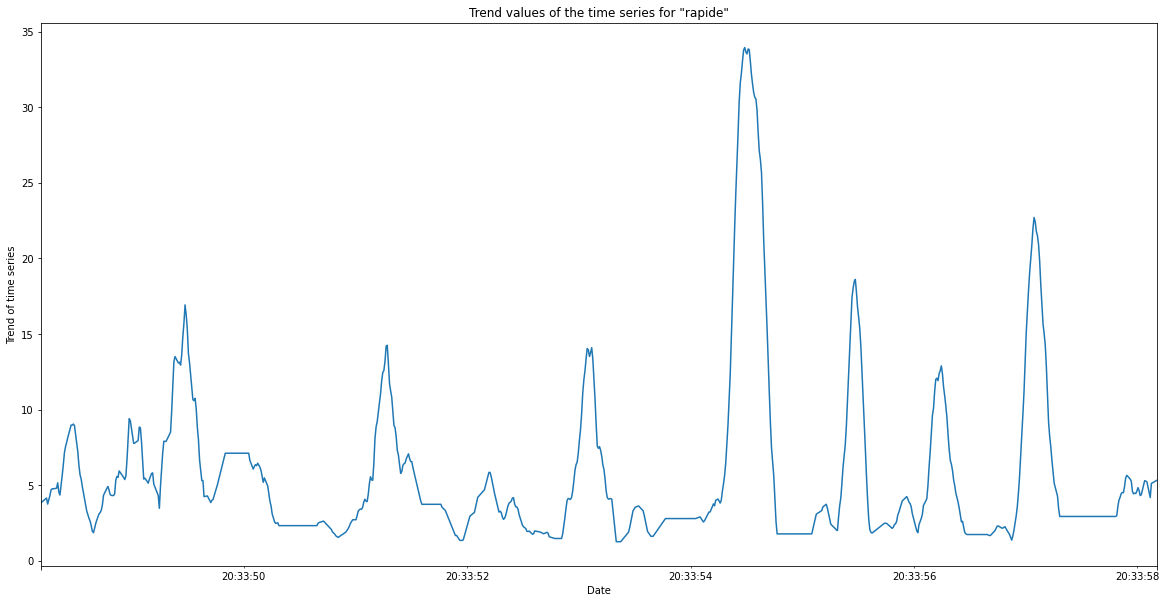

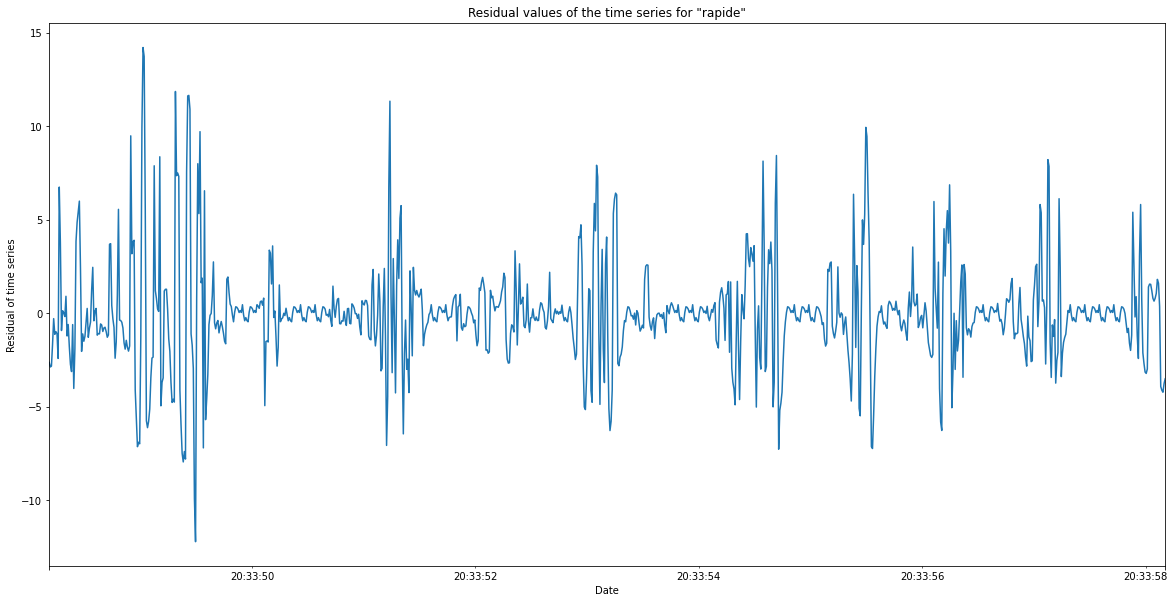

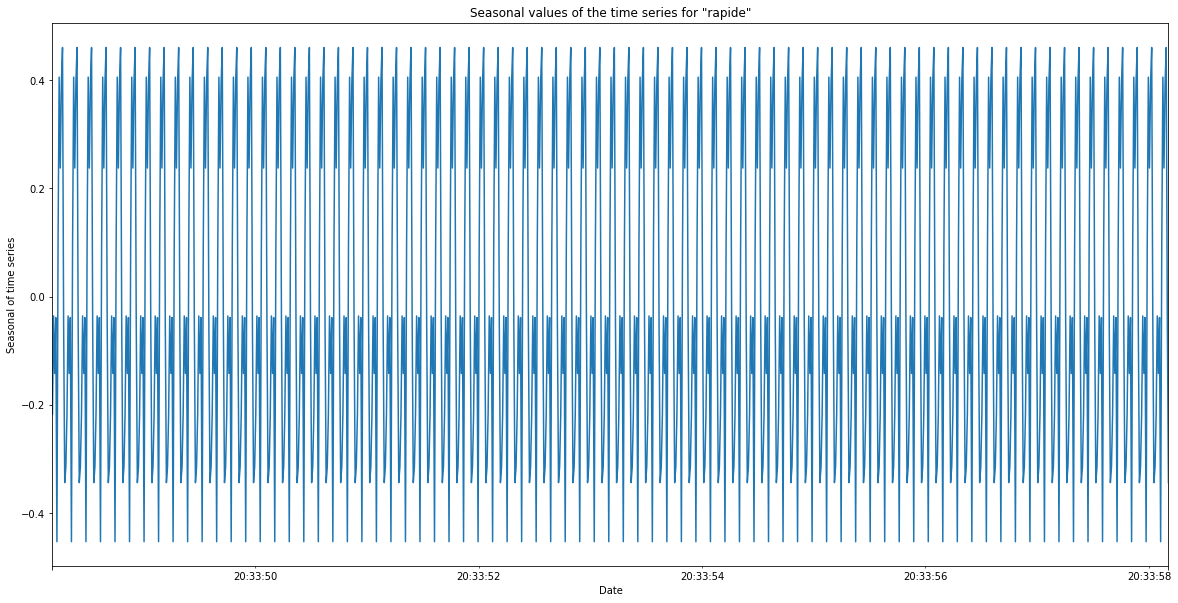

range => 
0 days 00:07:22.300500


Fpz
2022-10-29 20:35:53.865   1.840691
2022-10-29 20:35:53.875   1.977694
2022-10-29 20:35:53.885  -0.444232
2022-10-29 20:35:53.895   1.253499
2022-10-29 20:35:53.905   2.379543
...                            ...
2022-10-29 20:36:03.815  -9.077492
2022-10-29 20:36:03.825 -10.117601
2022-10-29 20:36:03.835  -4.549812
2022-10-29 20:36:03.845   0.185330
2022-10-29 20:36:03.855  -1.355028

[1000 rows x 1 columns]

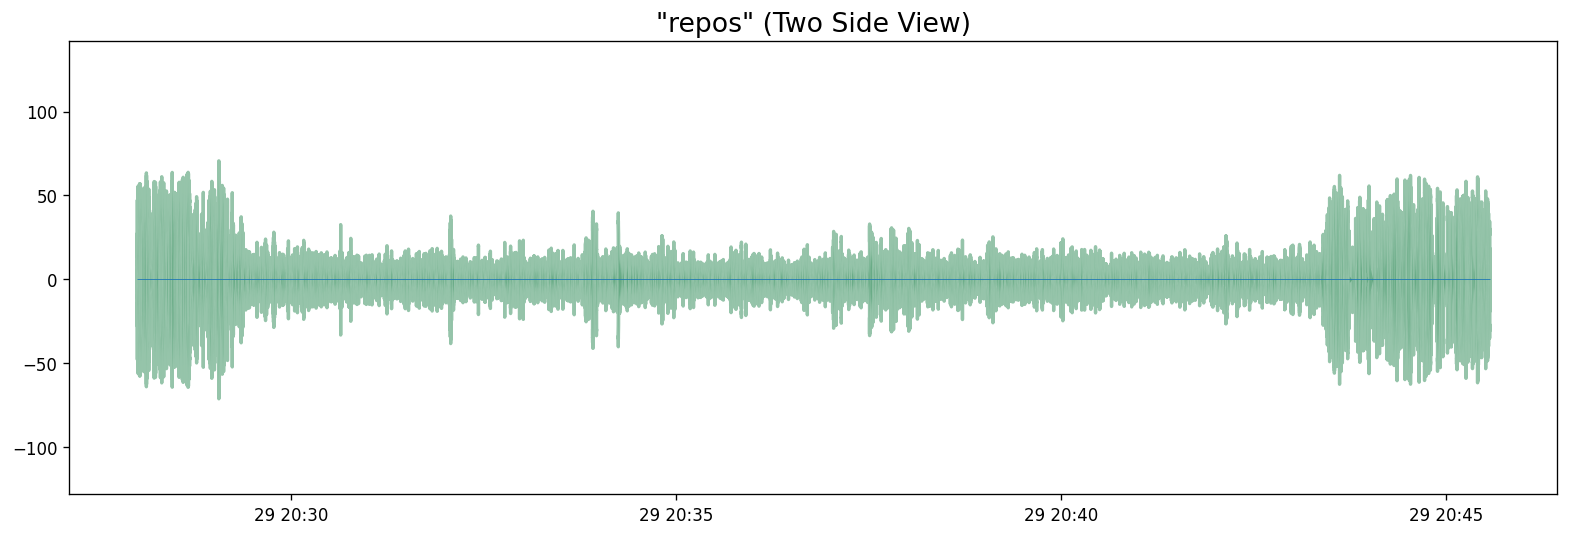

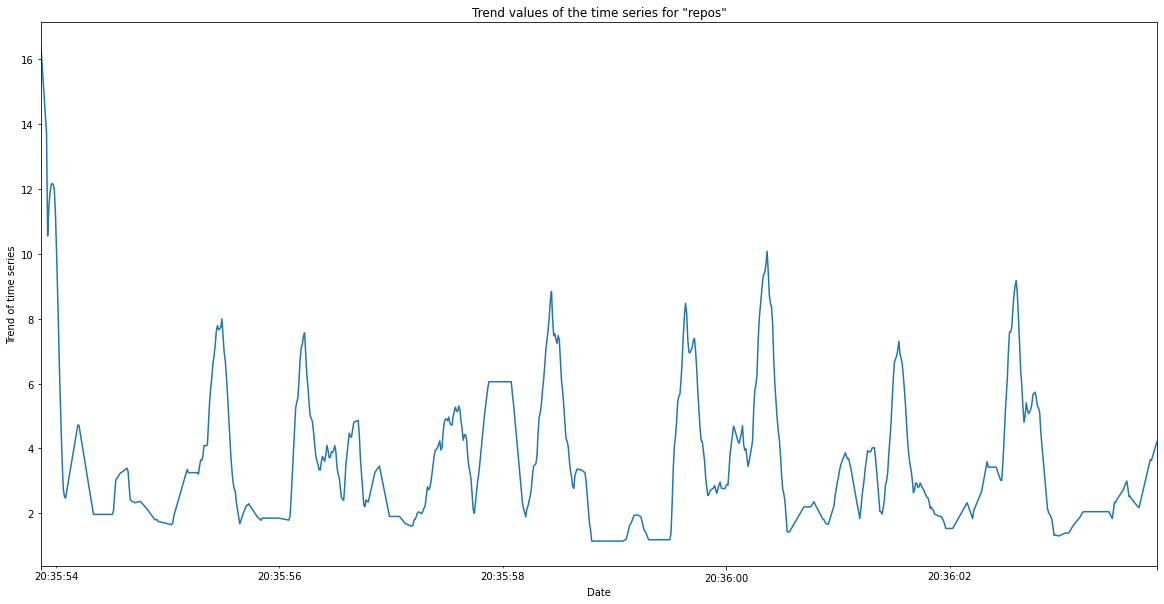

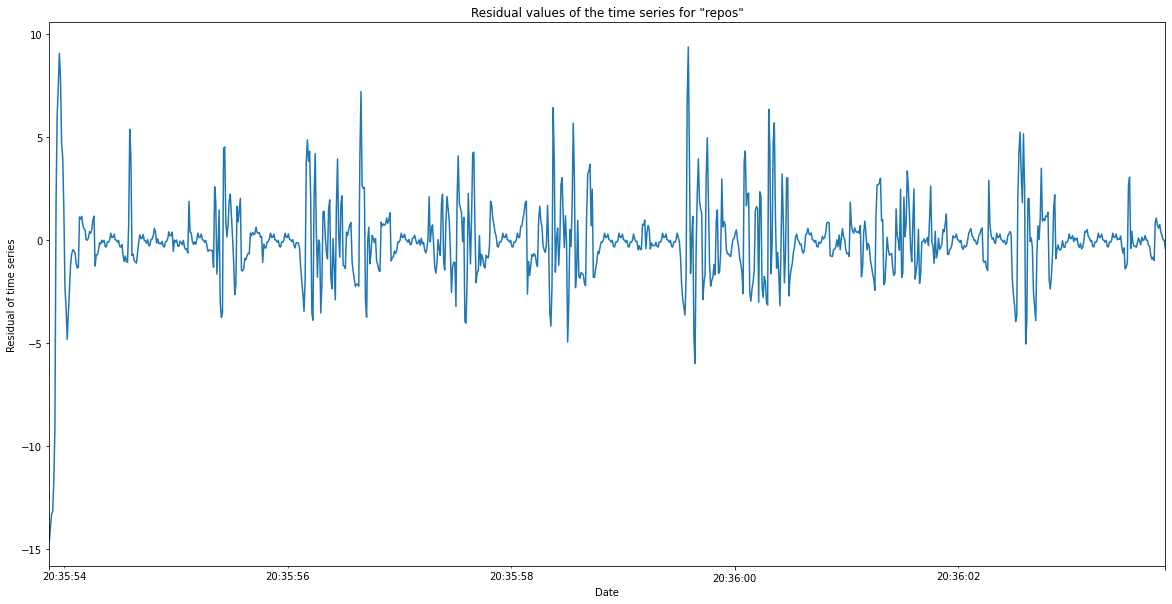

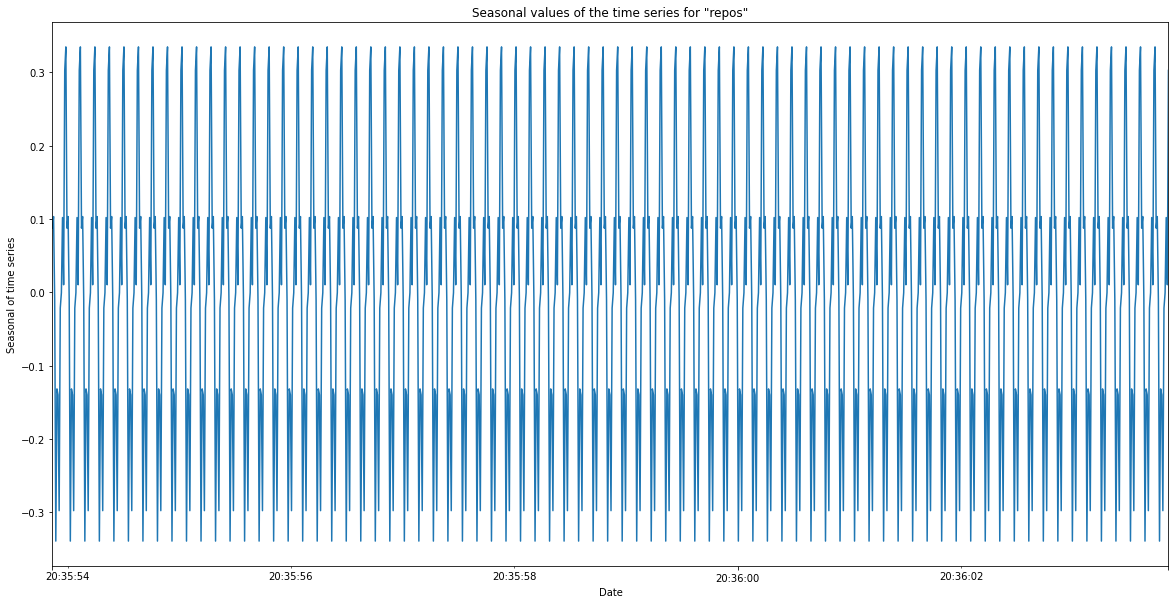

range => 
0 days 00:02:02.618500


/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/3513213301.py:37: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


Fpz
2022-10-29 20:36:57.445 -6.179463
2022-10-29 20:36:57.455 -9.167909
2022-10-29 20:36:57.465 -6.624706
2022-10-29 20:36:57.475 -2.844569
2022-10-29 20:36:57.485 -1.447070
...                           ...
2022-10-29 20:37:07.395  3.691758
2022-10-29 20:37:07.405 -0.903673
2022-10-29 20:37:07.415  0.027642
2022-10-29 20:37:07.425  4.211653
2022-10-29 20:37:07.435  6.913816

[1000 rows x 1 columns]

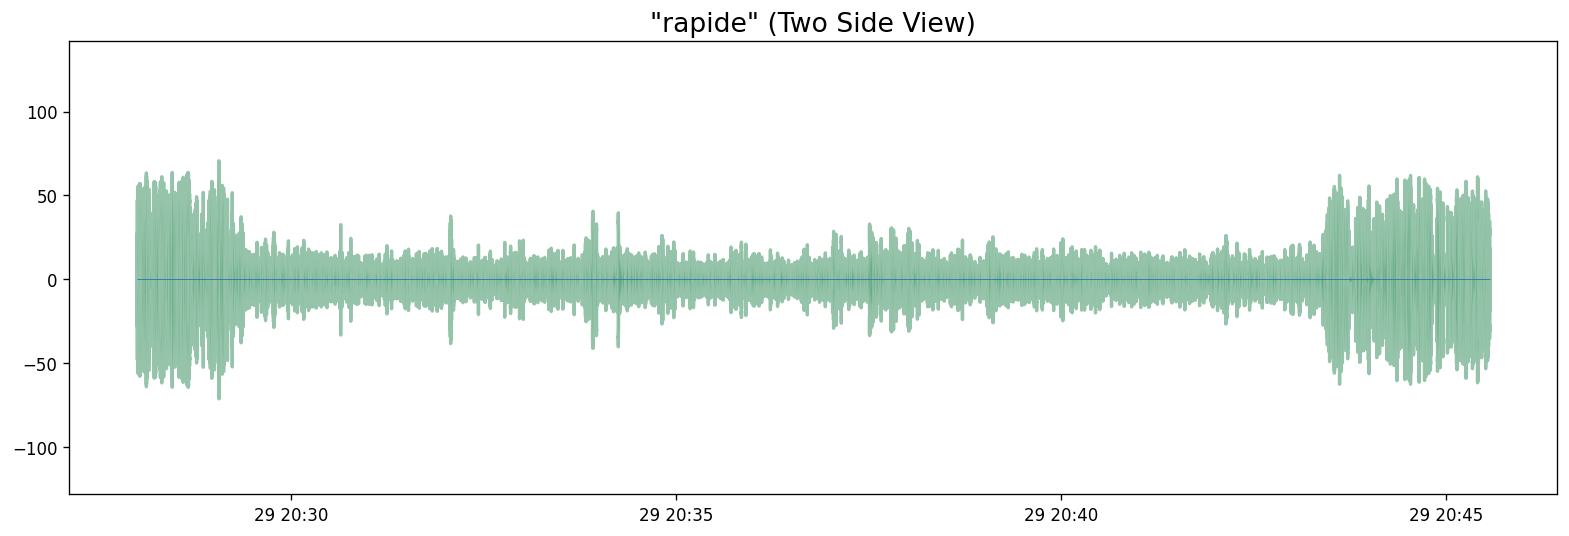

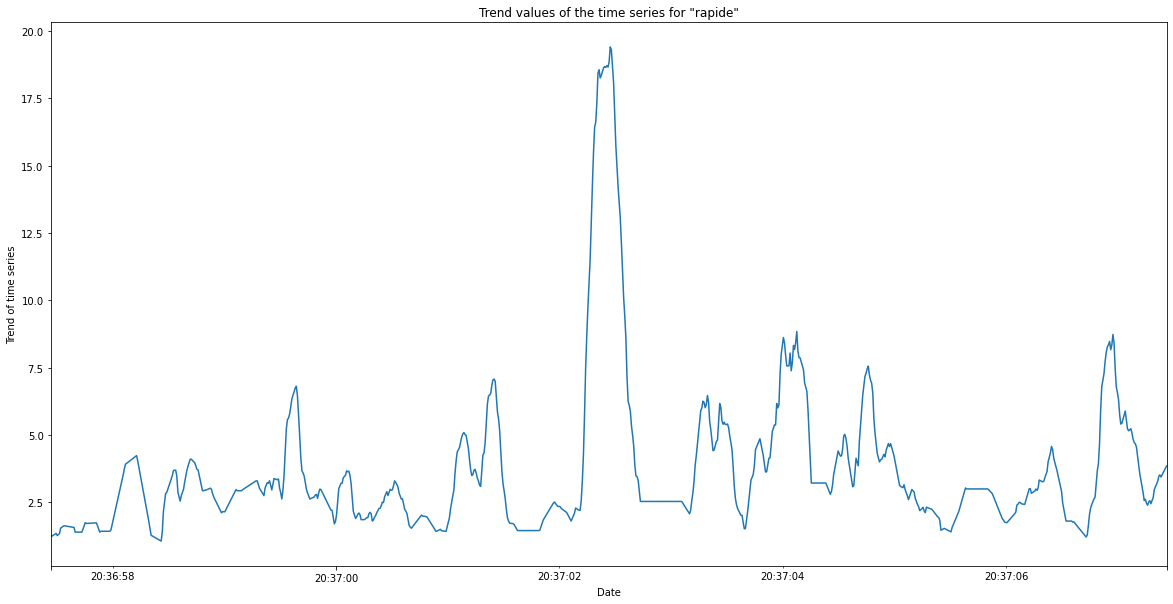

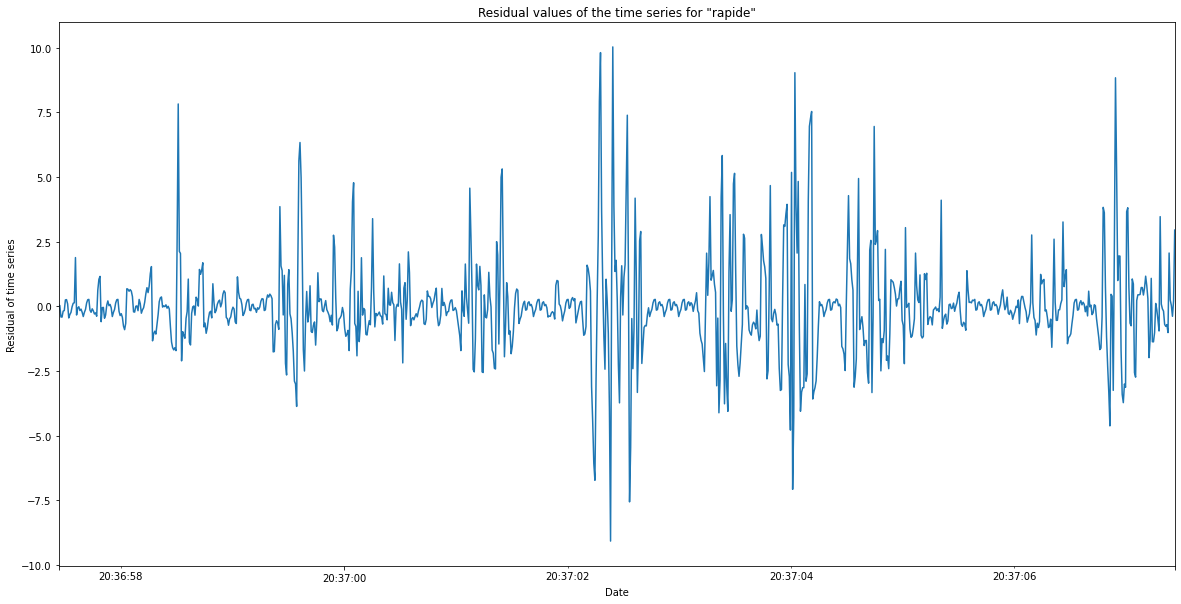

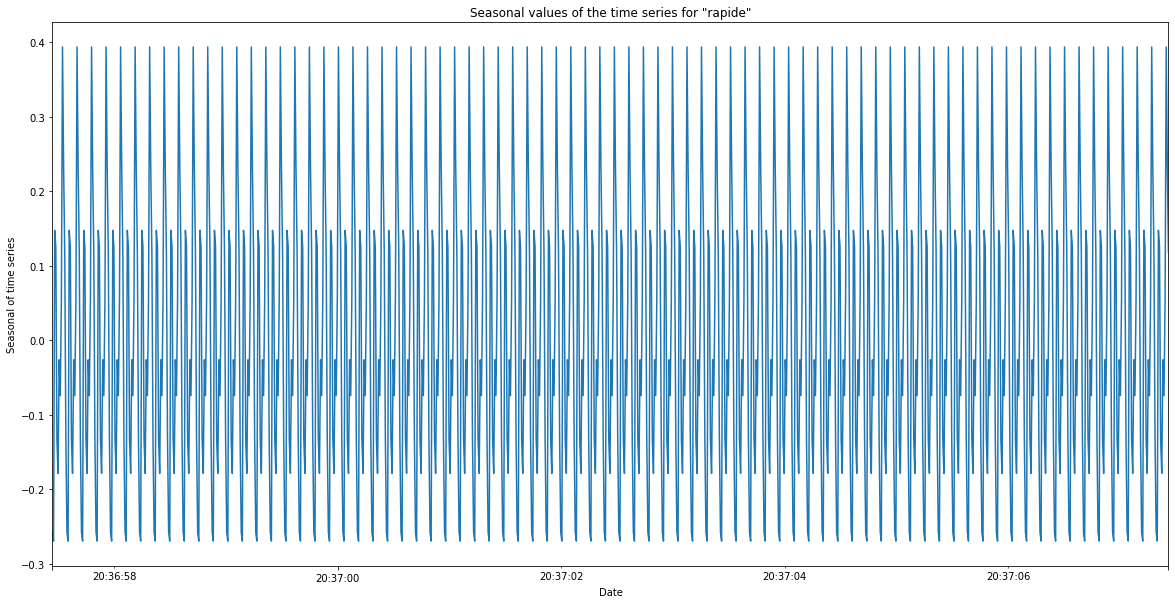

range => 
0 days 00:04:16.098600098


Fpz
2022-10-29 20:39:00.065  0.172655
2022-10-29 20:39:00.075 -0.254641
2022-10-29 20:39:00.085 -2.995827
2022-10-29 20:39:00.095 -4.149310
2022-10-29 20:39:00.105 -1.509202
...                           ...
2022-10-29 20:39:10.015 -2.052014
2022-10-29 20:39:10.025 -3.250356
2022-10-29 20:39:10.035 -4.385372
2022-10-29 20:39:10.045 -3.634180
2022-10-29 20:39:10.055 -1.169186

[1000 rows x 1 columns]

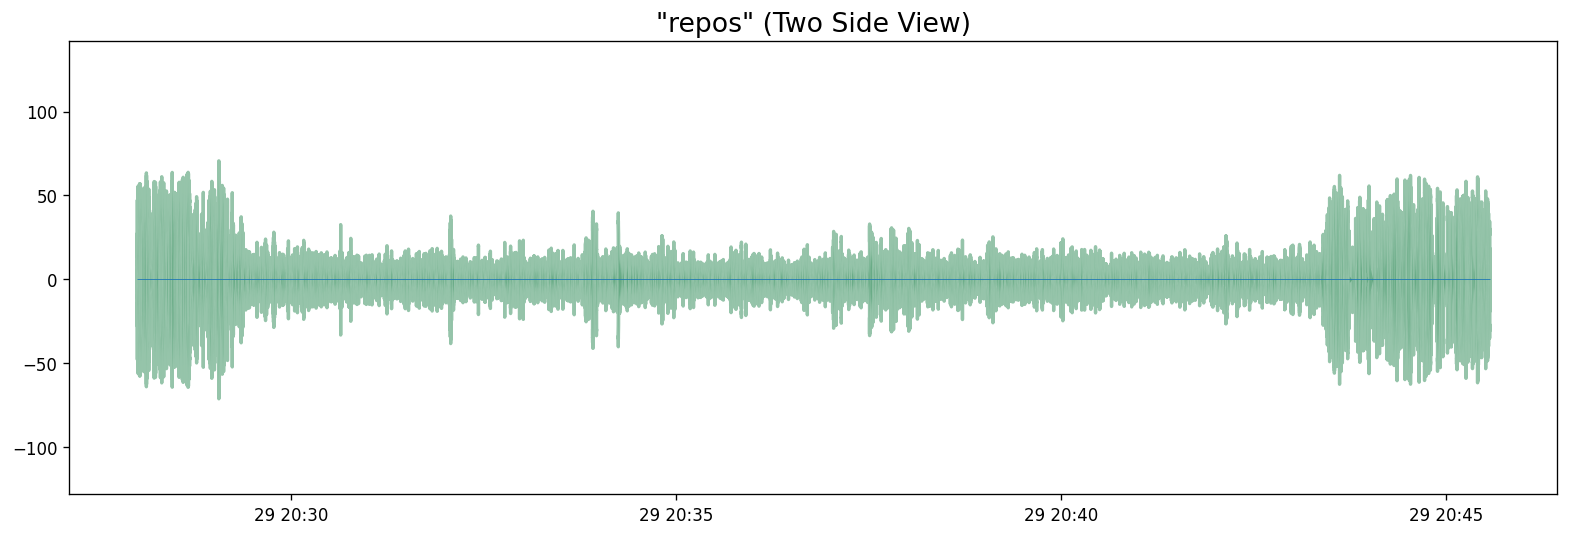

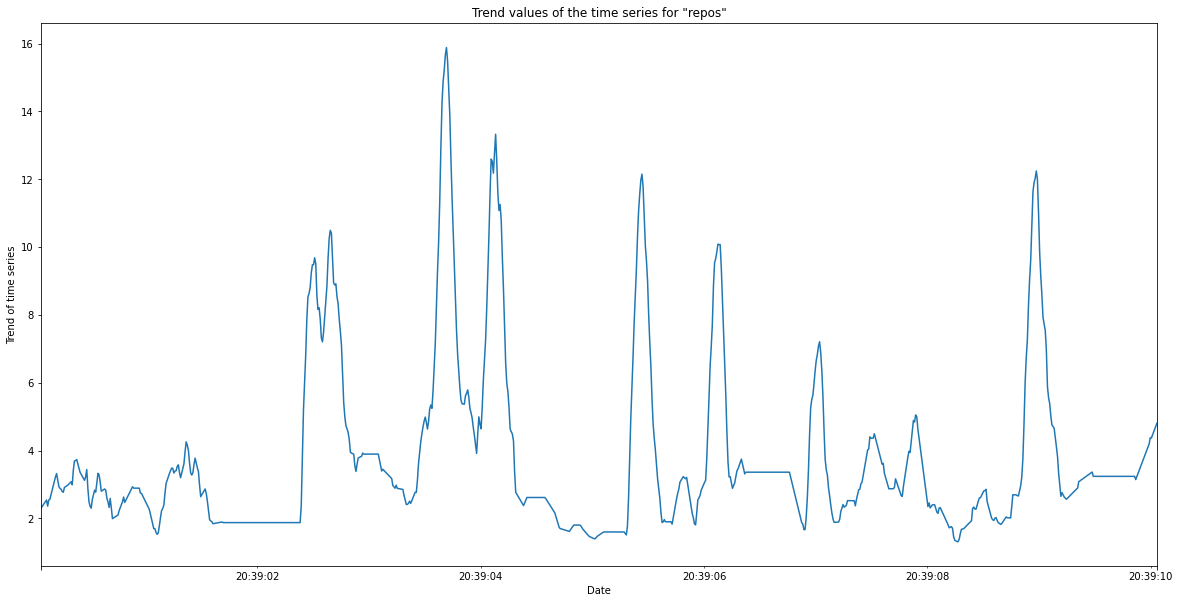

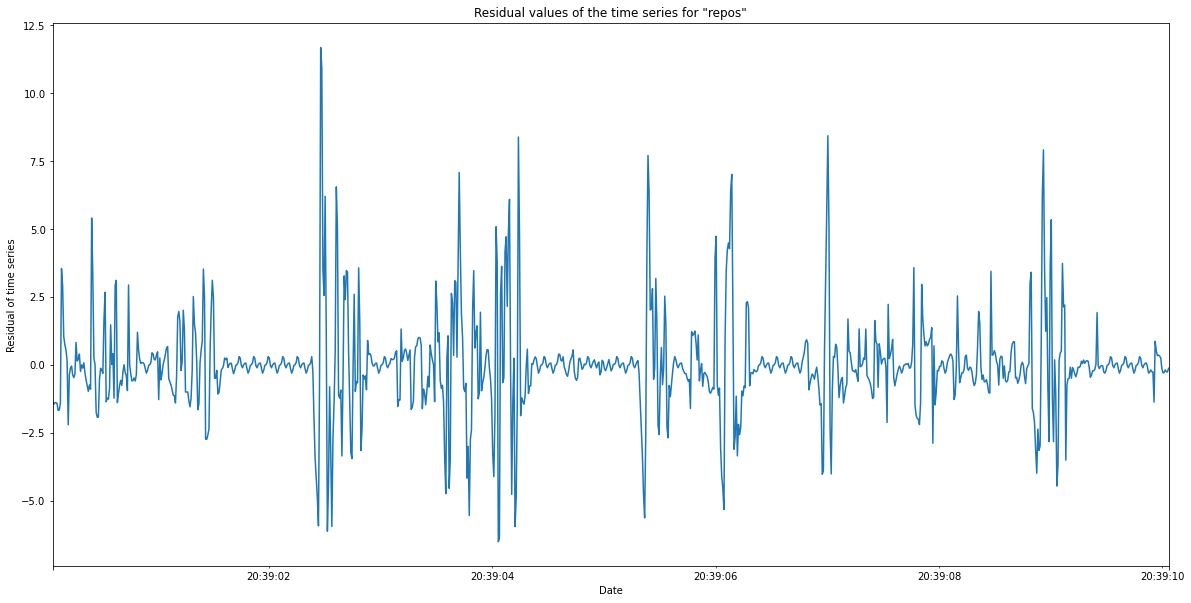

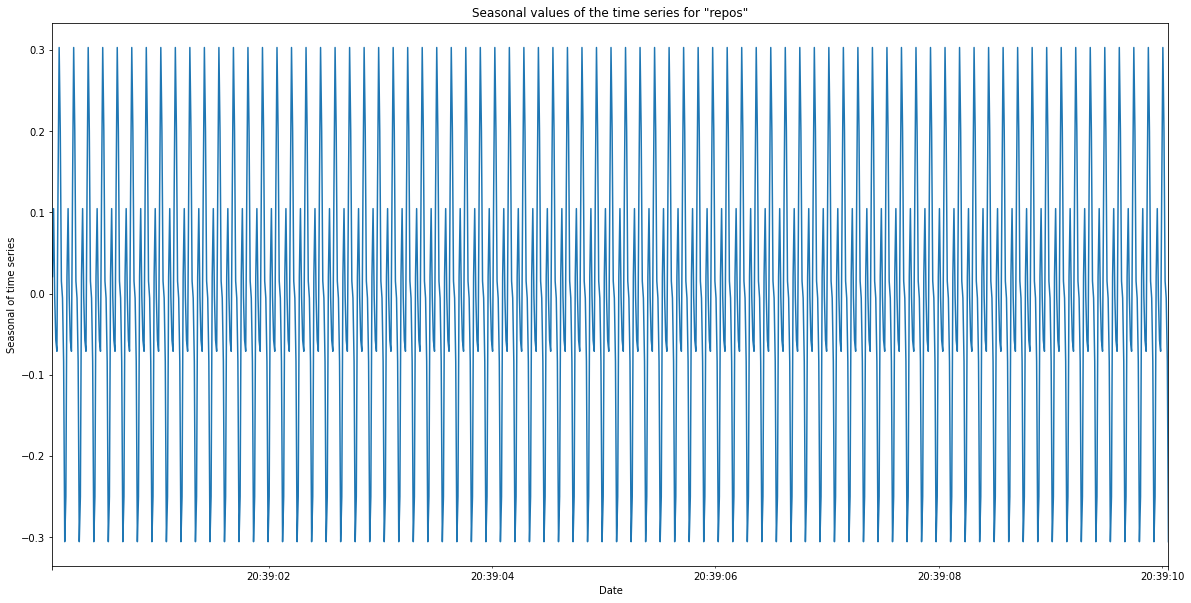

range => 
0 days 00:01:59.886000


/var/folders/s9/mx70pkk11bq2wl2cnrt6nfwc0000gn/T/ipykernel_17340/3513213301.py:37: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  end = event_df.index[event_df.index.get_loc(ref_start_date, method='ffill') + 1]


Fpz
2022-10-29 20:40:04.215  0.567513
2022-10-29 20:40:04.225 -3.455450
2022-10-29 20:40:04.235 -6.663158
2022-10-29 20:40:04.245 -8.259610
2022-10-29 20:40:04.255 -7.982336
...                           ...
2022-10-29 20:40:14.165  1.857051
2022-10-29 20:40:14.175 -0.933213
2022-10-29 20:40:14.185 -6.677923
2022-10-29 20:40:14.195 -4.780781
2022-10-29 20:40:14.205 -0.452714

[1000 rows x 1 columns]

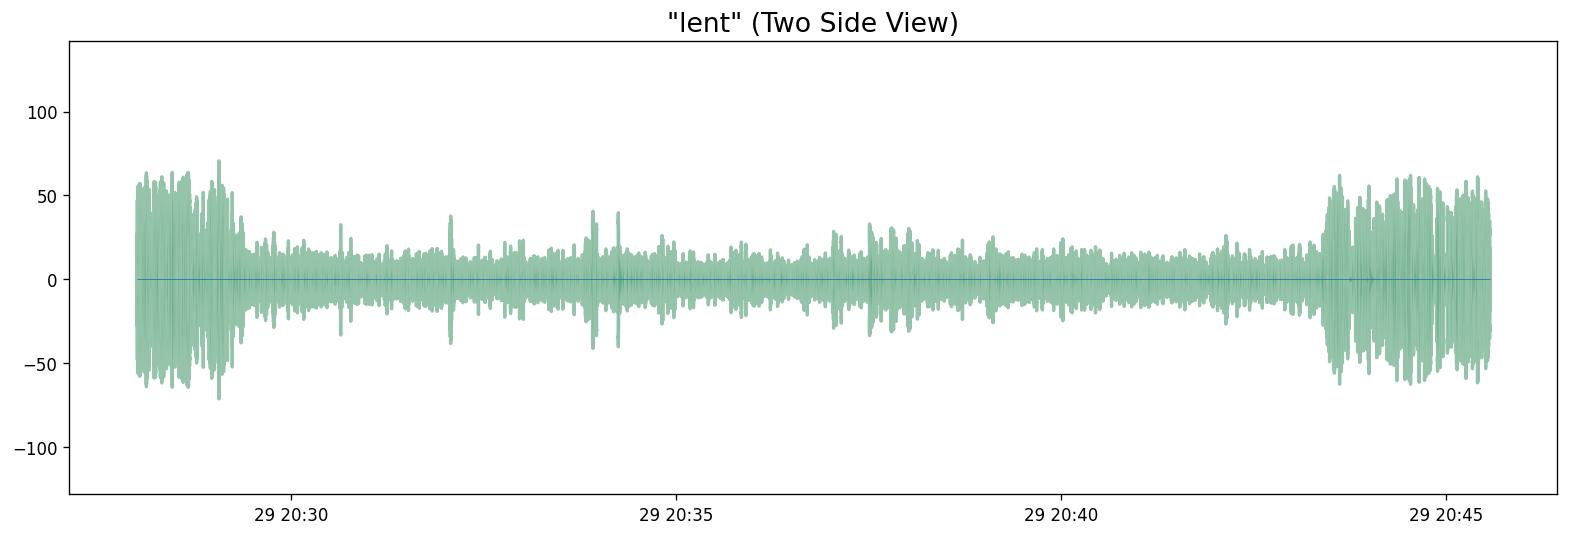

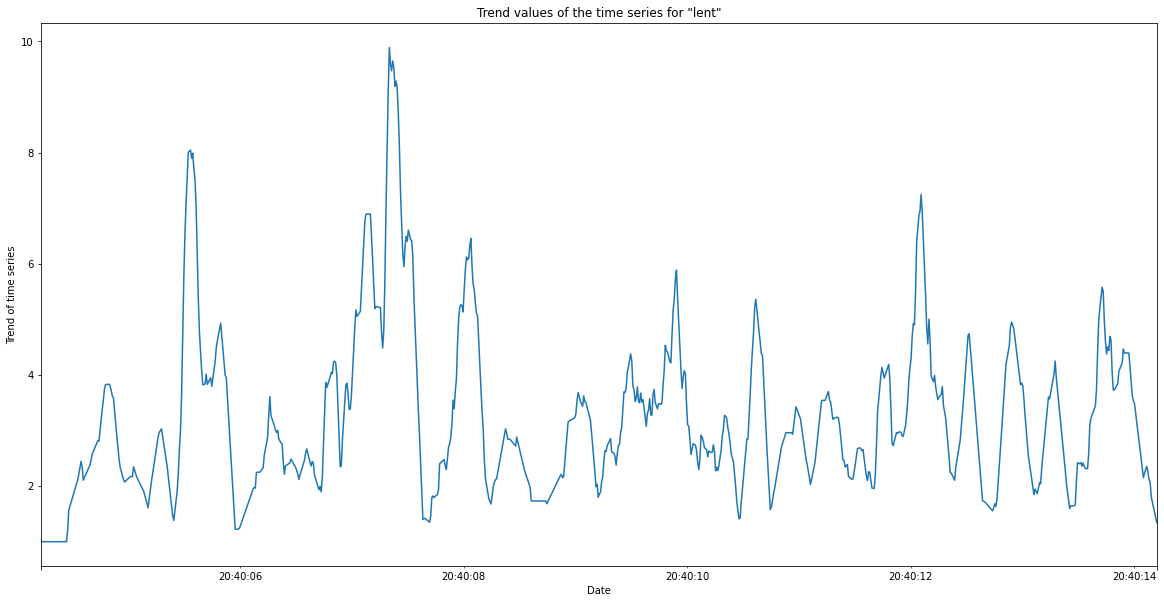

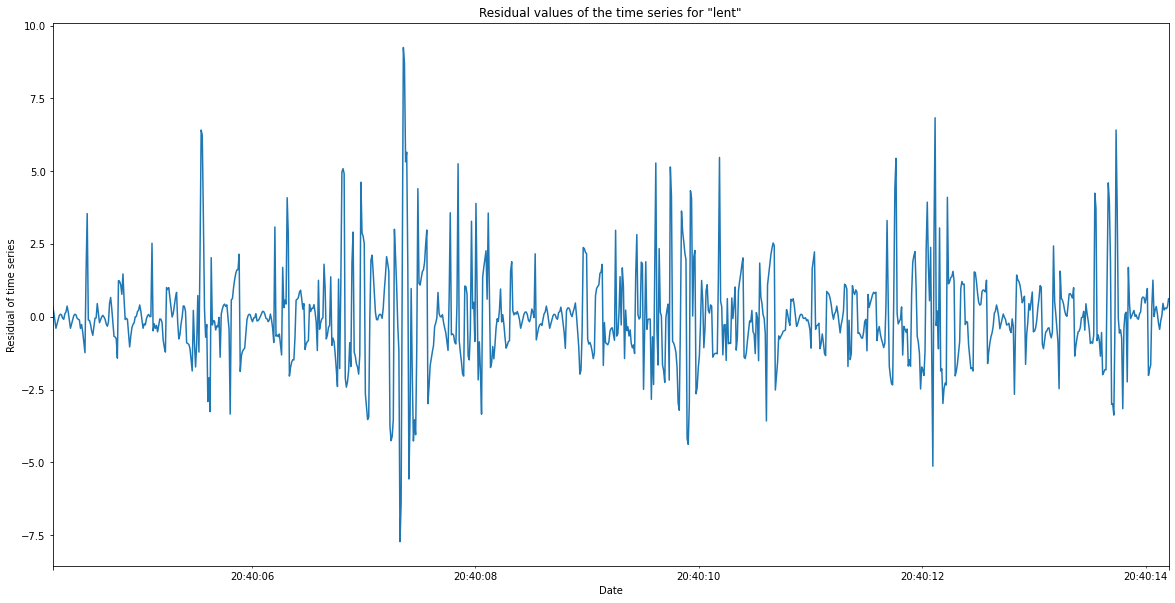

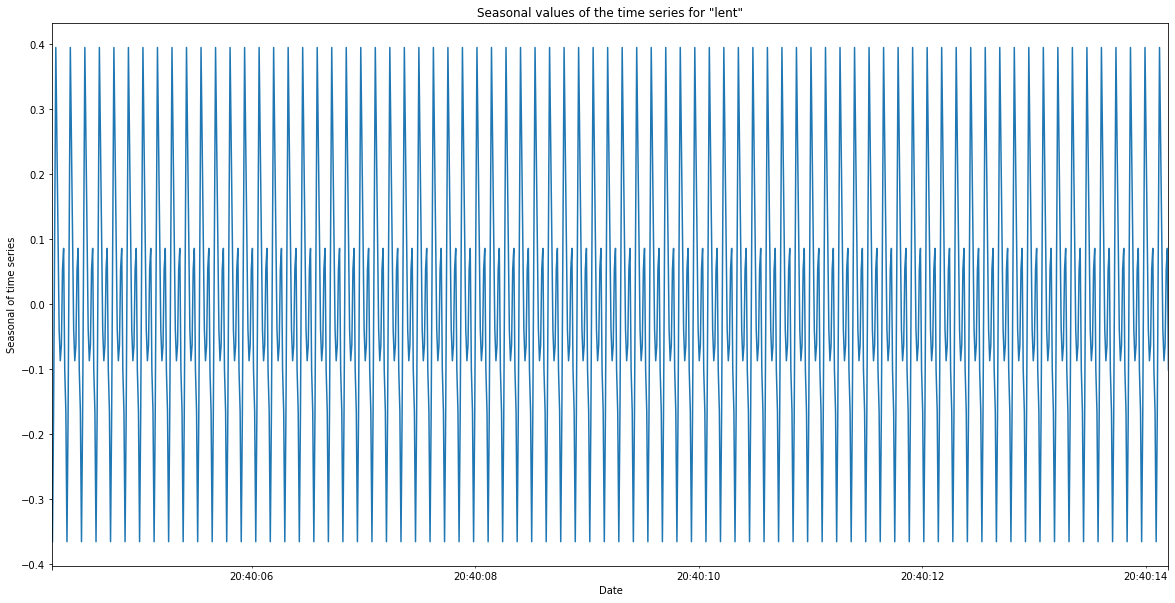

range => 
0 days 00:01:12.064100098


Fpz
2022-10-29 20:42:04.105  0.379857
2022-10-29 20:42:04.115 -1.371475
2022-10-29 20:42:04.125  1.782994
2022-10-29 20:42:04.135  1.604996
2022-10-29 20:42:04.145 -4.556021
...                           ...
2022-10-29 20:42:14.055 -4.976789
2022-10-29 20:42:14.065 -2.351265
2022-10-29 20:42:14.075 -2.525946
2022-10-29 20:42:14.085 -5.394955
2022-10-29 20:42:14.095 -4.820418

[1000 rows x 1 columns]

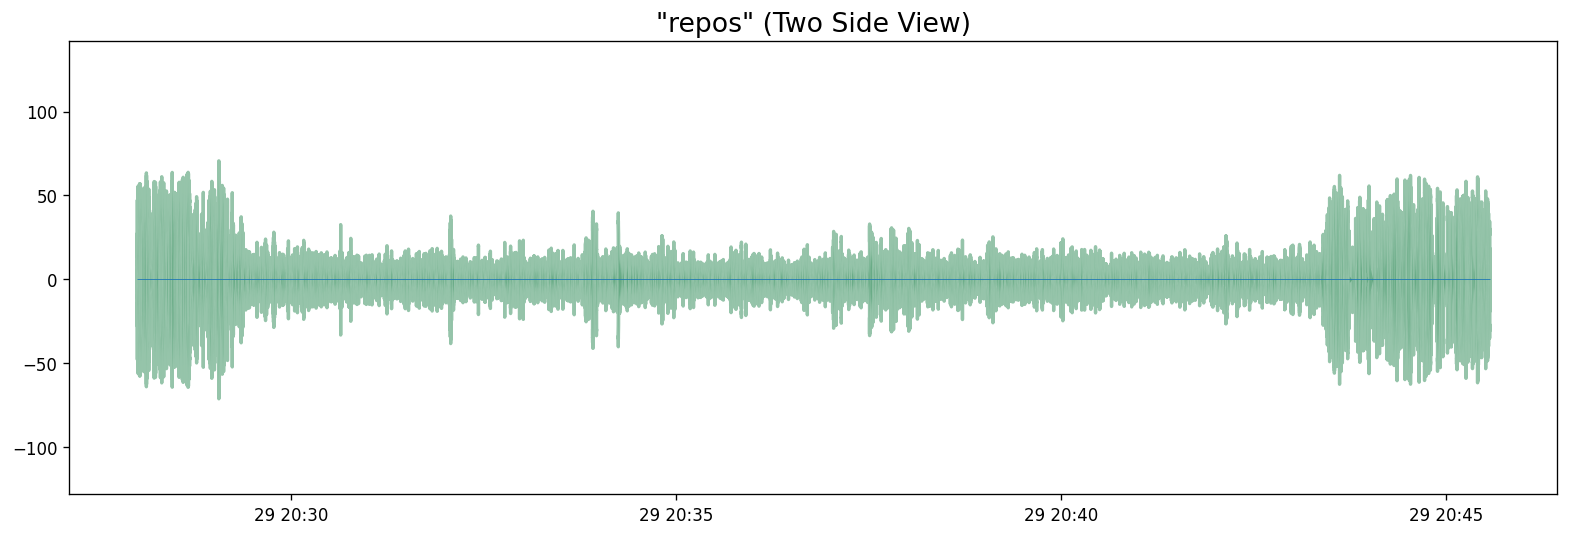

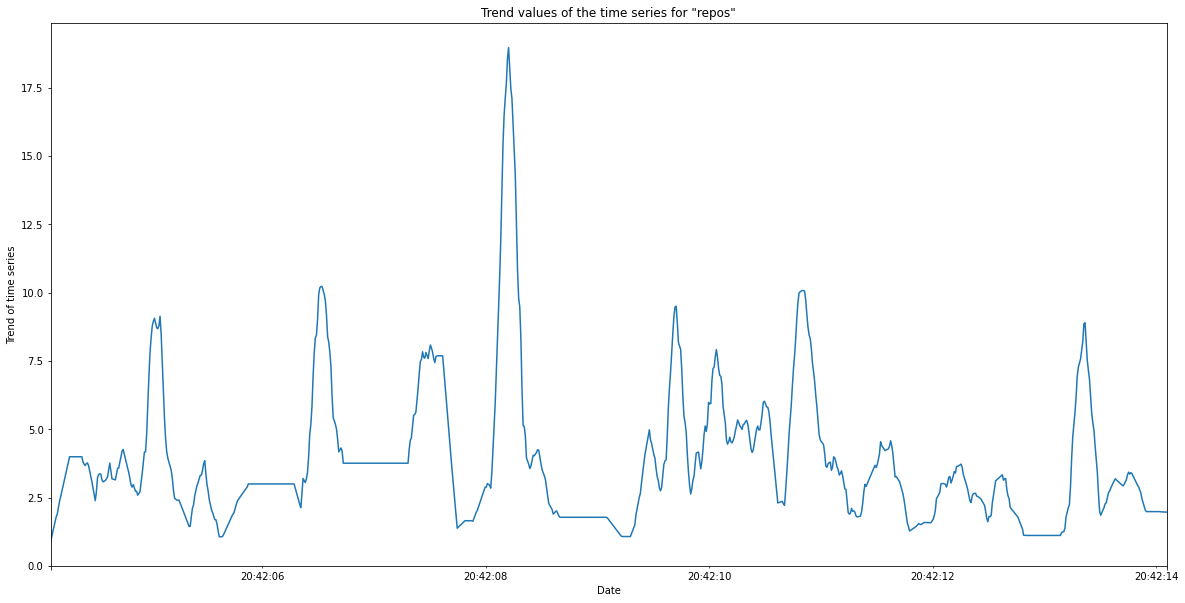

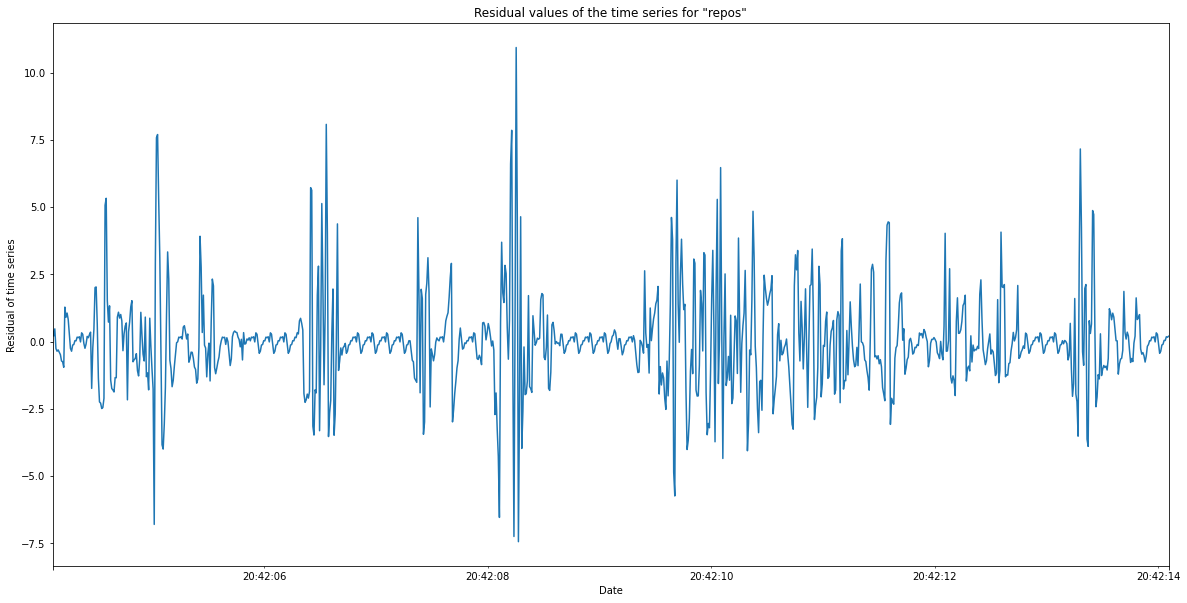

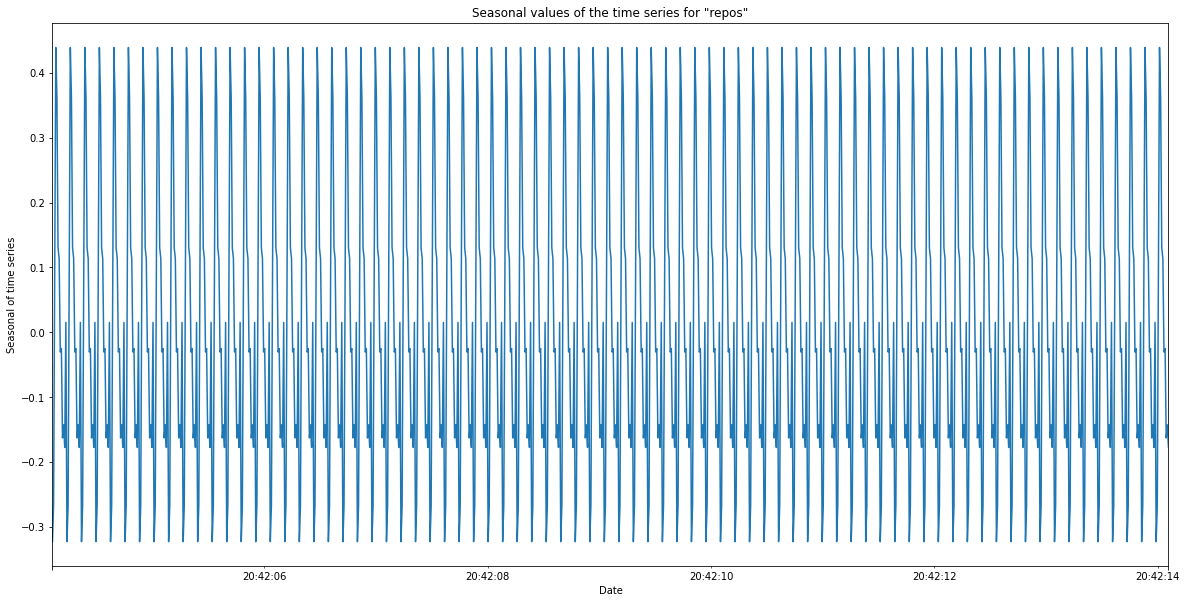

In [213]:
viz_ts_by_class(df_filtered, df_events)